# Similarity measures for tracking
The IFT relies on similarity metrics to filter candidate floes and to find a best match. The similarity metrics are evaluated in order of increasing complexity:

1. Maximum distance as a function of time
2. Absolute difference ratios for standard geometric measures
3. $\psi\text{-}s$ correlation
4. Minimal shape difference under rotation

The travel distance threshold is parameterized based on IABP drifting buoy data. See notebook `tracker_distance_threshold.ipynb` for details.

The remaining metrics are investigated using two experiments: rotating floes automatically, and pairing floes in the validation dataset. 

What I've been assembling with these various tests and experiments is some quantitative information on how the measures used by the IFT relate to variation across ice floes, variation from errors from rotation, and how much confidence we can have in the recovered rotation and shape difference estimates. I've been setting up Julia scripts to test the IFT functions and run experiments.

Prior to running this notebook, the following Julia scripts need to have been run:
1. `rotation_test_floe_shapes.jl` 
2. `matched_pairs_test_floe_shapes.jl` 

Other scripts for potential later analysis:
1. `rotation_sd_experiment_rectangles.jl` Generates rectangles with a list of areas and aspect ratios, then computes the error in rotation estimates and the minimum shape difference. We can use this to see what sizes of shapes can be recovered with confidence.
2. `rotation_sd_experiment_ellipses.jl` (TBD: adapt old code, and generate single images to analyze without saving them).


# Determining optimal thresholds for the absolute difference ratios
Floes that are within the maximum travel distance are compared using the absolute difference ratio:
$$ ADR(X, Y) = \left|\frac{X - Y}{X + Y}\right|$$

We can then define the following metrics for a pair of floes $f$ and $g$:

* $ADR_{\text{area}} = ADR(\mbox{area}(f), \mbox{area}(g))$
* $ADR_{\text{convex}} = ADR(\mbox{convex\_area}(f), \mbox{convex\_area}(g))$
* $ADR_{\text{axmin}} = ADR(\mbox{axis\_minor\_length}(f), \mbox{axis\_minor\_length}(g))$
* $ADR_{\text{axmaj}} = ADR(\mbox{axis\_major\_length}(f), \mbox{axis\_major\_length}(g))$

The original paper sets a minimum and maximum floe size, then divides the remaining floes into small and large floes. The thresholds are set differently form the small and large categories.


|Floe Size|Area|Convex Area|Major Axis Length|Minor Axis Length|
| :- | -: | -: | -: | -: |
|Area < 1200 px|0.18|0.09|0.07|0.08|
|Area > 1200 px|0.28|0.14|0.10|0.12|


Using the rotation and matched-pair data, we ask the following questions:

* How sensitive is each measure to the uncertainty in the floe shape?
* How confident can we be in rejecting a match based on the results of the measures?
* How much power does each measure have at rejecting false matches?
* How much does the measure depend on the area of the floe?
* Is there a natural separation between "small" and "large" floes?


## TBD update
- In the plot_adr_thresholds script, let's filter out the floes that are largely cloud-covered
- We'll need to select and merge data from the matched pairs tables, also. Perhaps an additional python script, or an addition to the julia script.

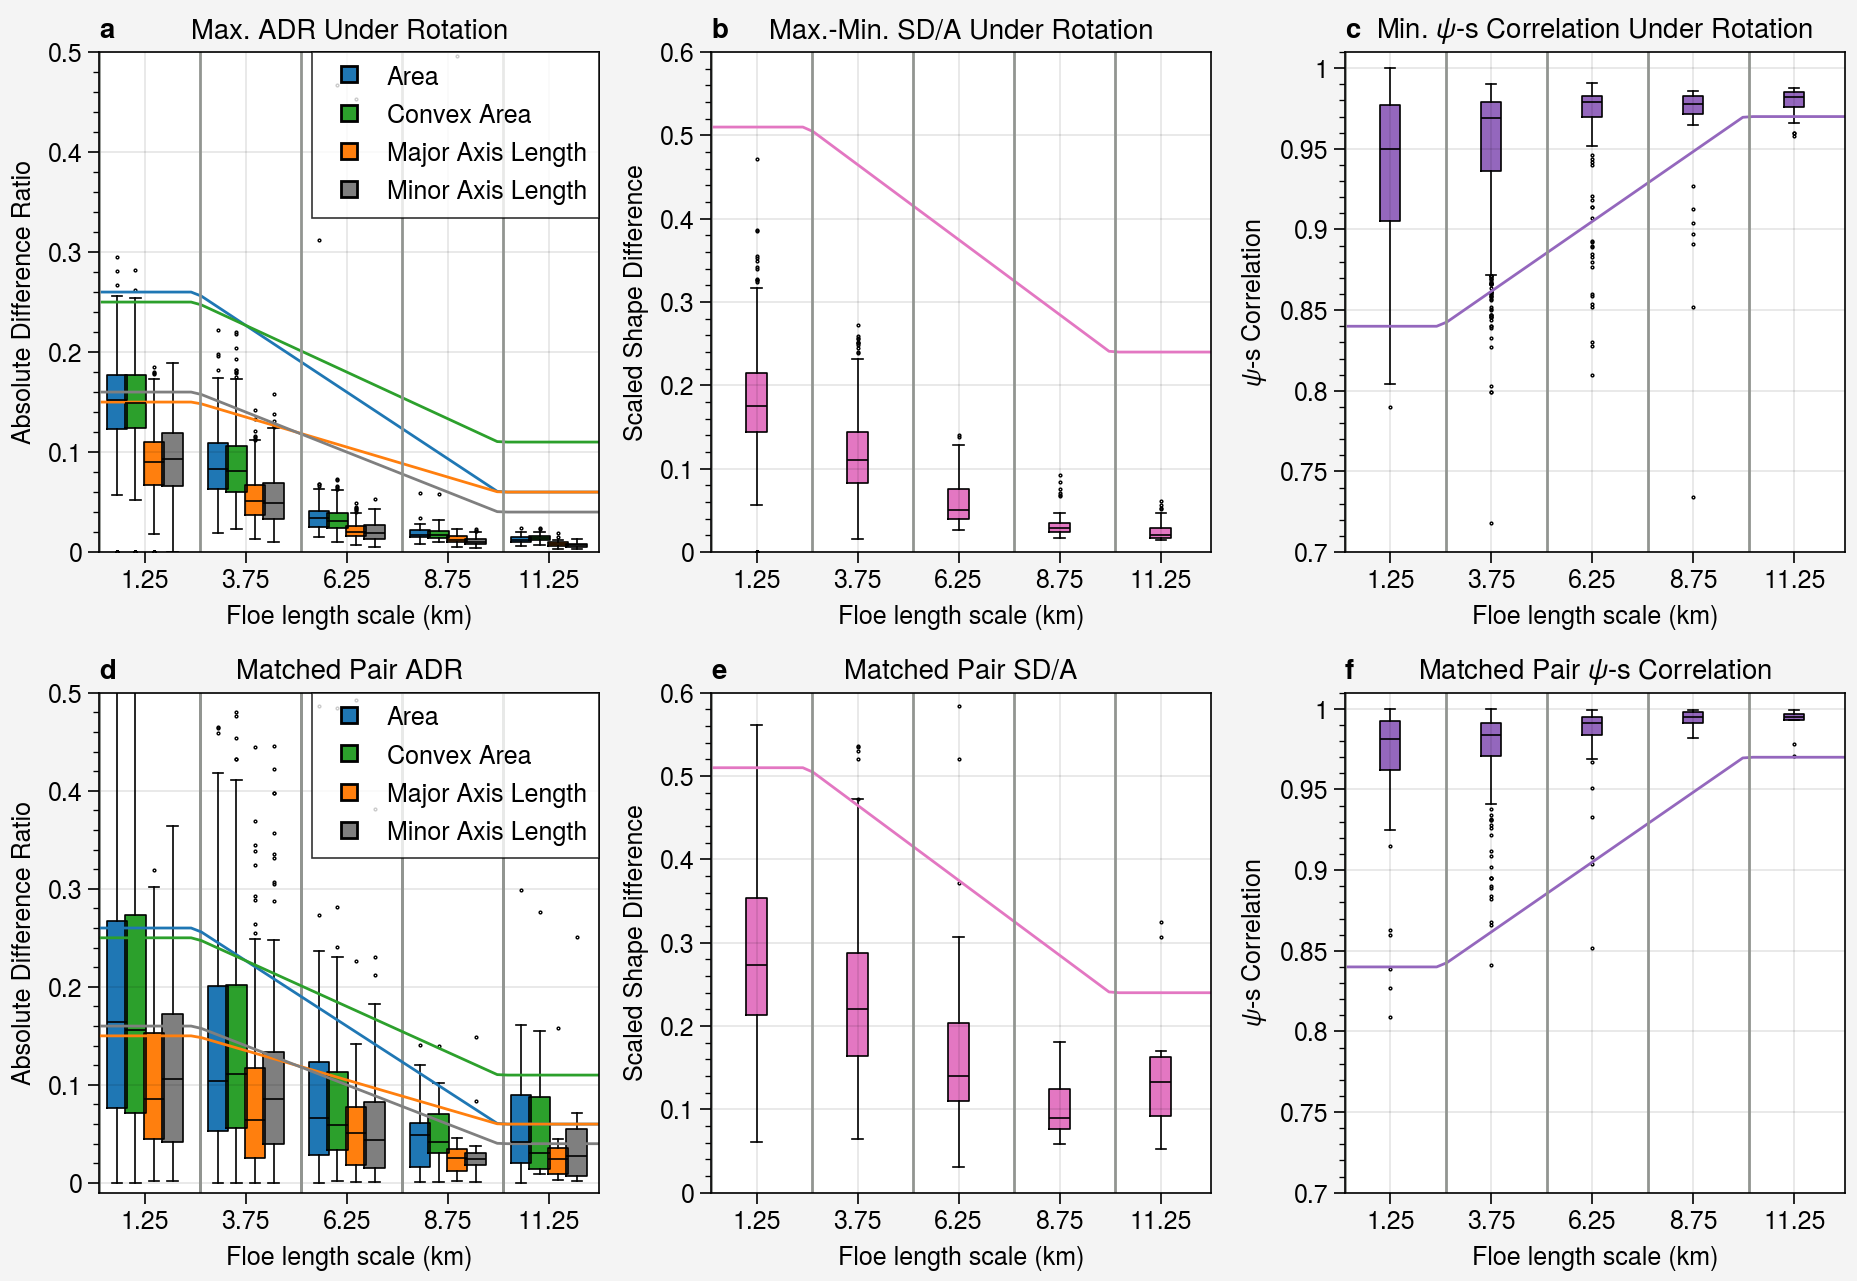

In [7]:
%run ../scripts/plot_adr_sd_psi_s_results.py

In [6]:
df_matched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   aqua_label                       967 non-null    int64  
 1   terra_label                      967 non-null    int64  
 2   aqua_area                        967 non-null    float64
 3   aqua_convex_area                 967 non-null    float64
 4   aqua_major_axis_length           967 non-null    float64
 5   aqua_minor_axis_length           967 non-null    float64
 6   aqua_perimeter                   967 non-null    float64
 7   aqua_perimeter_crofton           967 non-null    float64
 8   aqua_perimeter_boundary_pixels   967 non-null    float64
 9   terra_area                       967 non-null    float64
 10  terra_convex_area                967 non-null    float64
 11  terra_major_axis_length          967 non-null    float64
 12  terra_minor_axis_lengt

Index(['case', 'area', 'L', 'convex_area', 'major_axis_length',
       'minor_axis_length', 'max_area', 'max_convex_area',
       'max_major_axis_length', 'max_minor_axis_length', 'max_adr_area',
       'max_adr_convex_area', 'max_adr_major_axis_length',
       'max_adr_minor_axis_length', 'area_bin'],
      dtype='object')


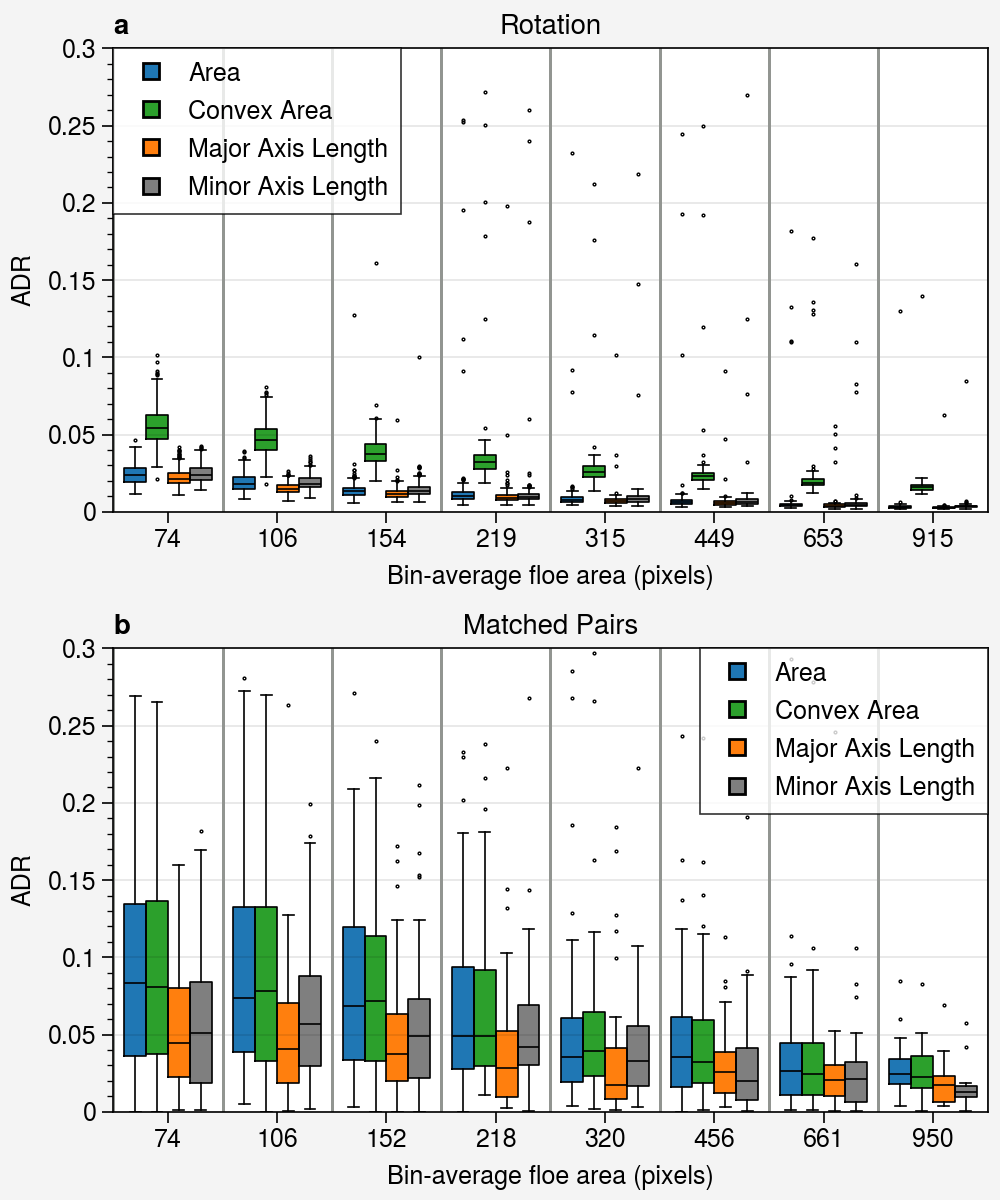

In [114]:
%run ../scripts/plot_adr_thresholds.py

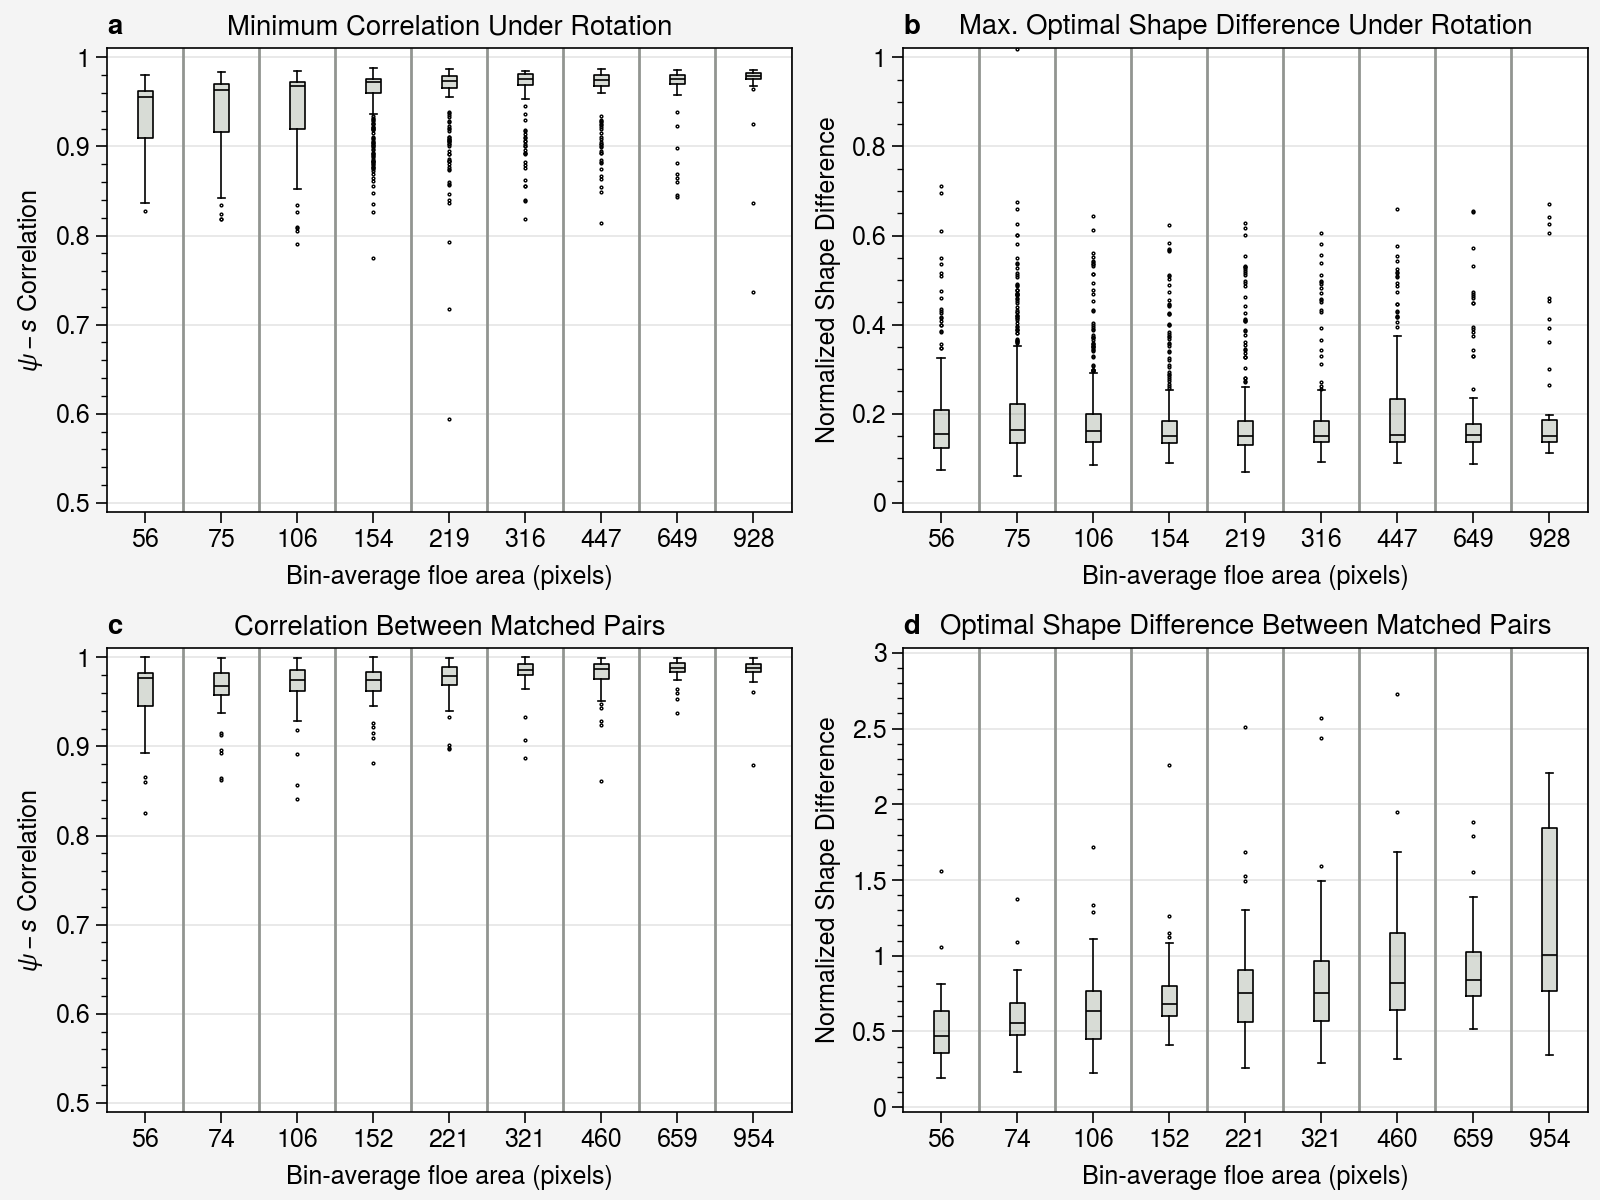

In [145]:
%run ../scripts/plot_psi_s_shape_difference.py

In [122]:
df_mg[['area_bin', 'adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']].groupby('area_bin').quantile(0.99).loc[10:14]

,adr_area,adr_convex_area,adr_major_axis_length,adr_minor_axis_length
area_bin,,,,
10,0.325457,0.345192,0.176045,0.260276
11,0.391955,0.388608,0.159750,0.291190
12,0.295149,0.291525,0.242490,0.111488
13,0.112268,0.104705,0.066694,0.069379
14,0.069622,0.073090,0.060796,0.068078


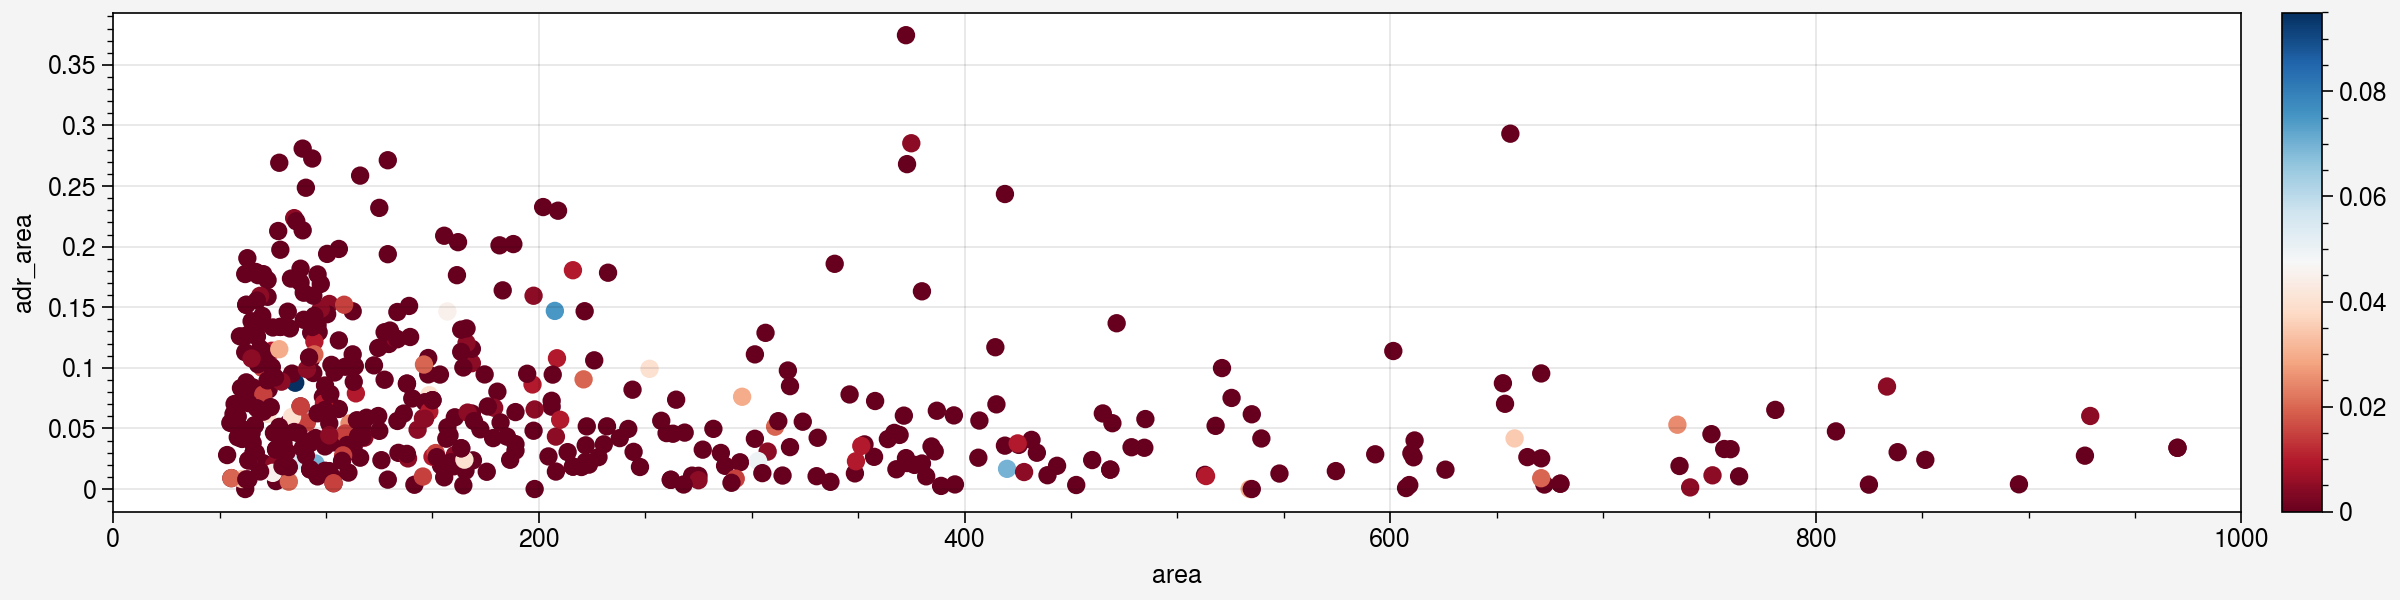

In [129]:
fig, ax = pplt.subplots(width=12, height=3)
idx = df_mg[['terra_cloud_fraction', 'aqua_cloud_fraction']].mean(axis=1) < 0.1
ax.scatter(df_mg.loc[idx, 'area'], df_mg.loc[idx, 'adr_area'],
           c=df_mg.loc[idx, ['terra_cloud_fraction', 'aqua_cloud_fraction']].mean(axis=1), cmap='RdBu', colorbar='r')
ax.format(xlim=(0, 1000))

In [66]:
print("Number of objects (prior to test/train split)")
print("Total floes:", rotated_bin_count['area_count'].sum())
print("Matched floes:", matched_bin_count['area_count'].sum())

Number of objects (prior to test/train split)
Total floes: 1854
Matched floes: 1004


In [131]:
# note: in the paper, abs diff to mean ratio is used. That's equal to 2 times the abs diff ratio I'm using.
small_floes = {'area': 0.18 / 2,
               'convex_area': 0.09 / 2,
               'minor_axis': 0.08 / 2,
               'major_axis': 0.07 / 2}
large_floes = {'area': 0.28 / 2,
               'convex_area': 0.14 / 2,
               'minor_axis': 0.12 / 2,
               'major_axis': 0.10 / 2}

# Cut off for small vs large floes at 300 pixels based on this analysis
small_floes_update = {'area': 0.3,
               'convex_area': 0.3,
               'minor_axis': 0.2,
               'major_axis': 0.2}

large_floes_update = {'area': 0.15,
                      'convex_area': 0.15,
                      'minor_axis': 0.12,
                      'major_axis': 0.12}

In [132]:
large_floes

{'area': 0.14, 'convex_area': 0.07, 'minor_axis': 0.06, 'major_axis': 0.05}

In [133]:
large_floes_update

{'area': 0.15, 'convex_area': 0.15, 'minor_axis': 0.12, 'major_axis': 0.12}

In [134]:
print("Small floes (n=", sum(df_mg.area < 1200), ")")
print("False negative rate, ADR area criteria: ",
      np.round((df_mg.loc[df_mg.area < 1200, 'adr_area'] > small_floes['area']).mean(), 2))
print("False negative rate, ADR convex area criteria: ", 
      np.round((df_mg.loc[df_mg.area < 1200, 'adr_convex_area'] > small_floes['convex_area']).mean(), 2))
print("False negative rate, ADR major axis criteria: ", 
      np.round((df_mg.loc[df_mg.area < 1200, 'adr_major_axis_length'] > small_floes['major_axis']).mean(), 2))
print("False negative rate, ADR convex area criteria: ", 
      np.round((df_mg.loc[df_mg.area < 1200, 'adr_minor_axis_length'] > small_floes['minor_axis']).mean(), 2))

print("\n")
print("Large floes (n=", sum(df_mg.area >= 1200), ")")
print("False negative rate, ADR area criteria: ",
      np.round((df_mg.loc[df_mg.area >= 1200, 'adr_area'] > large_floes['area']).mean(), 2))
print("False negative rate, ADR convex area criteria: ", 
      np.round((df_mg.loc[df_mg.area >= 1200, 'adr_convex_area'] > large_floes['convex_area']).mean(), 2))
print("False negative rate, ADR major axis criteria: ", 
      np.round((df_mg.loc[df_mg.area >= 1200, 'adr_major_axis_length'] > large_floes['major_axis']).mean(), 2))
print("False negative rate, ADR convex area criteria: ", 
      np.round((df_mg.loc[df_mg.area >= 1200, 'adr_minor_axis_length'] > large_floes['minor_axis']).mean(), 2))


Small floes (n= 547 )
False negative rate, ADR area criteria:  0.33
False negative rate, ADR convex area criteria:  0.6
False negative rate, ADR major axis criteria:  0.48
False negative rate, ADR convex area criteria:  0.51


Large floes (n= 34 )
False negative rate, ADR area criteria:  0.03
False negative rate, ADR convex area criteria:  0.12
False negative rate, ADR major axis criteria:  0.09
False negative rate, ADR convex area criteria:  0.06


In [135]:
df_matched_test = df_matched.loc[~df_matched.training,:]
print("Small floes (n=", sum(df_matched_test.area < 1200), ")")
print("False negative rate, ADR area criteria: ",
      np.round((df_matched_test.loc[df_matched_test.area < 1200, 'adr_area'] > small_floes_update['area']).mean(), 2))
print("False negative rate, ADR convex area criteria: ", 
      np.round((df_matched_test.loc[df_matched_test.area < 1200, 'adr_convex_area'] > small_floes_update['convex_area']).mean(), 2))
print("False negative rate, ADR major axis criteria: ", 
      np.round((df_matched_test.loc[df_matched_test.area < 1200, 'adr_major_axis_length'] > small_floes_update['major_axis']).mean(), 2))
print("False negative rate, ADR convex area criteria: ", 
      np.round((df_matched_test.loc[df_matched_test.area < 1200, 'adr_minor_axis_length'] > small_floes_update['minor_axis']).mean(), 2))

print("\n")
print("Large floes (n=", sum(df_matched_test.area >= 1200), ")")
print("False negative rate, ADR area criteria: ",
      np.round((df_matched_test.loc[df_matched_test.area >= 1200, 'adr_area'] > large_floes_update['area']).mean(), 2))
print("False negative rate, ADR convex area criteria: ", 
      np.round((df_matched_test.loc[df_matched_test.area >= 1200, 'adr_convex_area'] > large_floes_update['convex_area']).mean(), 2))
print("False negative rate, ADR major axis criteria: ", 
      np.round((df_matched_test.loc[df_matched_test.area >= 1200, 'adr_major_axis_length'] > large_floes_update['major_axis']).mean(), 2))
print("False negative rate, ADR convex area criteria: ", 
      np.round((df_matched_test.loc[df_matched_test.area >= 1200, 'adr_minor_axis_length'] > large_floes_update['minor_axis']).mean(), 2))


Small floes (n= 365 )
False negative rate, ADR area criteria:  0.03
False negative rate, ADR convex area criteria:  0.03
False negative rate, ADR major axis criteria:  0.02
False negative rate, ADR convex area criteria:  0.03


Large floes (n= 21 )
False negative rate, ADR area criteria:  0.0
False negative rate, ADR convex area criteria:  0.0
False negative rate, ADR major axis criteria:  0.0
False negative rate, ADR convex area criteria:  0.0


In [136]:
# df_matched_test[['case', 'adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']].groupby('case').max().max(axis=1).sort_values()
df_mg.loc[df_mg.case == '160']

,aqua_label,terra_label,aqua_area,aqua_convex_area,aqua_major_axis_length,aqua_minor_axis_length,aqua_perimeter,aqua_perimeter_crofton,terra_area,terra_convex_area,...,case,floe_id,area,perimeter,normalized_shape_difference,L,area_bin,aqua_cloud_fraction,terra_cloud_fraction,training
384,1,1,428.0,456.0,31.562154,17.794973,82.041631,80.461860,382.0,390.0,...,160,160_0001,405.0,77.798990,0.899755,20.124612,11,1.0,1.0,True
385,2,2,631.0,654.0,35.282301,23.493116,97.355339,94.980166,696.0,717.0,...,160,160_0002,663.5,99.769553,0.831917,25.758494,12,1.0,1.0,True
386,3,3,459.0,470.0,28.745280,20.610351,79.112698,77.685058,455.0,472.0,...,160,160_0003,457.0,82.305087,1.105642,21.377558,11,1.0,1.0,True
387,4,4,525.0,548.0,32.087064,20.911657,87.597980,85.959647,554.0,576.0,...,160,160_0004,539.5,89.133514,0.639490,23.227139,11,1.0,1.0,True
388,5,5,444.0,456.0,28.461214,19.937432,77.698485,76.344300,336.0,346.0,...,160,160_0005,390.0,72.991378,1.479627,19.748418,11,1.0,1.0,True
389,6,6,1068.0,1107.0,49.493497,29.284961,135.882251,131.505969,1075.0,1108.0,...,160,160_0006,1071.5,132.175144,1.460184,32.733775,13,1.0,1.0,True
390,7,7,270.0,284.0,27.497674,12.783974,67.112698,66.308345,150.0,161.0,...,160,160_0007,210.0,57.698485,2.149103,14.491377,9,1.0,1.0,True
391,9,8,106.0,112.0,15.569776,8.690395,38.142136,38.842529,104.0,107.0,...,160,160_0009,105.0,38.435029,0.650448,10.246951,7,1.0,1.0,True
392,10,9,1285.0,1342.0,49.978687,34.205986,144.468037,139.645805,1298.0,1372.0,...,160,160_0010,1291.5,146.124892,0.431138,35.937446,14,1.0,1.0,True
393,13,10,1505.0,1555.0,49.170148,39.836252,150.994949,145.833706,1498.0,1576.0,...,160,160_0013,1501.5,151.823376,0.876018,38.749194,14,1.0,1.0,True


# Results
* Uncertainty across matched pairs is much higher than uncertainty from rotation
* Very few floes in the largest bins. The bin sizes shown above are in pixels, because that makes the results independent of the image resolution. For MODIS, the bin sizes range from 3.4 km$^2$ to 58 km$^2$. That's quite a lot smaller than the "large floes" in Rosalinda's work.
* Using the original ADR thresholds as above results in very high false negative rate: most of the small floes are rejected.

In [396]:
import skimage as ski

dataloc = "/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/ice_floe_validation_dataset/"
case = '148-laptev_sea-20110324-aqua-binary_floes'
case = '140-hudson_bay-20100524-aqua-binary_floes'

bin_img = ski.io.imread(dataloc + "data/validation_dataset/binary_floes/" + case + ".png")
lb_img = ski.measure.label(bin_img[:,:,0])
props = pd.DataFrame(ski.measure.regionprops_table(lb_img, properties=['label', 'area', 'convex_area', 'major_axis_length',
                                                                       'minor_axis_length', 'perimeter_crofton', 'centroid']))
props.rename({'centroid-0': 'row_centroid', 'centroid-1': 'col_centroid'}, axis=1, inplace=True)
props.set_index('label', inplace=True)

bin_img0 = ski.io.imread(dataloc + "data/validation_dataset/binary_floes/" + case.replace('aqua', 'terra') + ".png")
lb_img0 = ski.measure.label(bin_img0[:,:,0])
props0 = pd.DataFrame(ski.measure.regionprops_table(lb_img0, properties=['label', 'area', 'convex_area', 'major_axis_length',
                                                                       'minor_axis_length', 'perimeter_crofton', 'centroid']))
props0.rename({'centroid-0': 'row_centroid', 'centroid-1': 'col_centroid'}, axis=1, inplace=True)
props0.set_index('label', inplace=True)

props.sort_values('area').tail(20)

,area,convex_area,major_axis_length,minor_axis_length,perimeter_crofton,row_centroid,col_centroid
label,,,,,,,
17,107.0,114.0,13.897660,9.944397,38.287169,342.925234,167.280374
15,109.0,118.0,16.915296,8.412611,41.754084,315.532110,151.596330
11,112.0,119.0,15.666290,9.240192,40.183288,267.705357,280.151786
14,114.0,121.0,18.172671,8.072517,42.864805,313.921053,137.280702
19,119.0,126.0,14.218838,10.804942,39.953250,373.773109,155.873950
1,171.0,175.0,16.410033,13.313809,46.657043,130.736842,81.321637
20,199.0,211.0,19.732315,13.298866,53.686158,387.718593,195.155779
10,209.0,226.0,19.936359,14.828444,57.938471,252.248804,349.196172
16,267.0,281.0,22.815761,14.995192,60.945311,324.876404,118.749064


In [401]:
label = 12
adr_area = np.zeros(lb_img.shape)
adr_convex_area = np.zeros(lb_img.shape)
adr_major_axis_length = np.zeros(lb_img.shape)
adr_minor_axis_length = np.zeros(lb_img.shape)

for var in ['area', 'convex_area', 'major_axis_length', 'minor_axis_length']:
    props['adr_' + var] =  abs((props.loc[label, var] - props.loc[:, var]) / \
                   (props.loc[label, var] + props.loc[:, var]))

for comp_label in props.index:
    adr_area[lb_img == comp_label] = props.loc[comp_label, 'adr_area']
    adr_convex_area[lb_img == comp_label] = props.loc[comp_label, 'adr_convex_area']
    adr_major_axis_length[lb_img == comp_label] = props.loc[comp_label, 'adr_major_axis_length']
    adr_minor_axis_length[lb_img == comp_label] = props.loc[comp_label, 'adr_minor_axis_length']

adr_area0 = np.zeros(lb_img.shape)
adr_convex_area0 = np.zeros(lb_img.shape)
adr_major_axis_length0 = np.zeros(lb_img.shape)
adr_minor_axis_length0 = np.zeros(lb_img.shape)

# Comparing to the label in the Aqua image
for var in ['area', 'convex_area', 'major_axis_length', 'minor_axis_length']:
    props0['adr_' + var] =  abs((props.loc[label, var] - props0.loc[:, var]) / \
                   (props.loc[label, var] + props0.loc[:, var]))

for comp_label in props0.index:
    adr_area0[lb_img0 == comp_label] = props0.loc[comp_label, 'adr_area']
    adr_convex_area0[lb_img0 == comp_label] = props0.loc[comp_label, 'adr_convex_area']
    adr_major_axis_length0[lb_img0 == comp_label] = props0.loc[comp_label, 'adr_major_axis_length']
    adr_minor_axis_length0[lb_img0 == comp_label] = props0.loc[comp_label, 'adr_minor_axis_length']

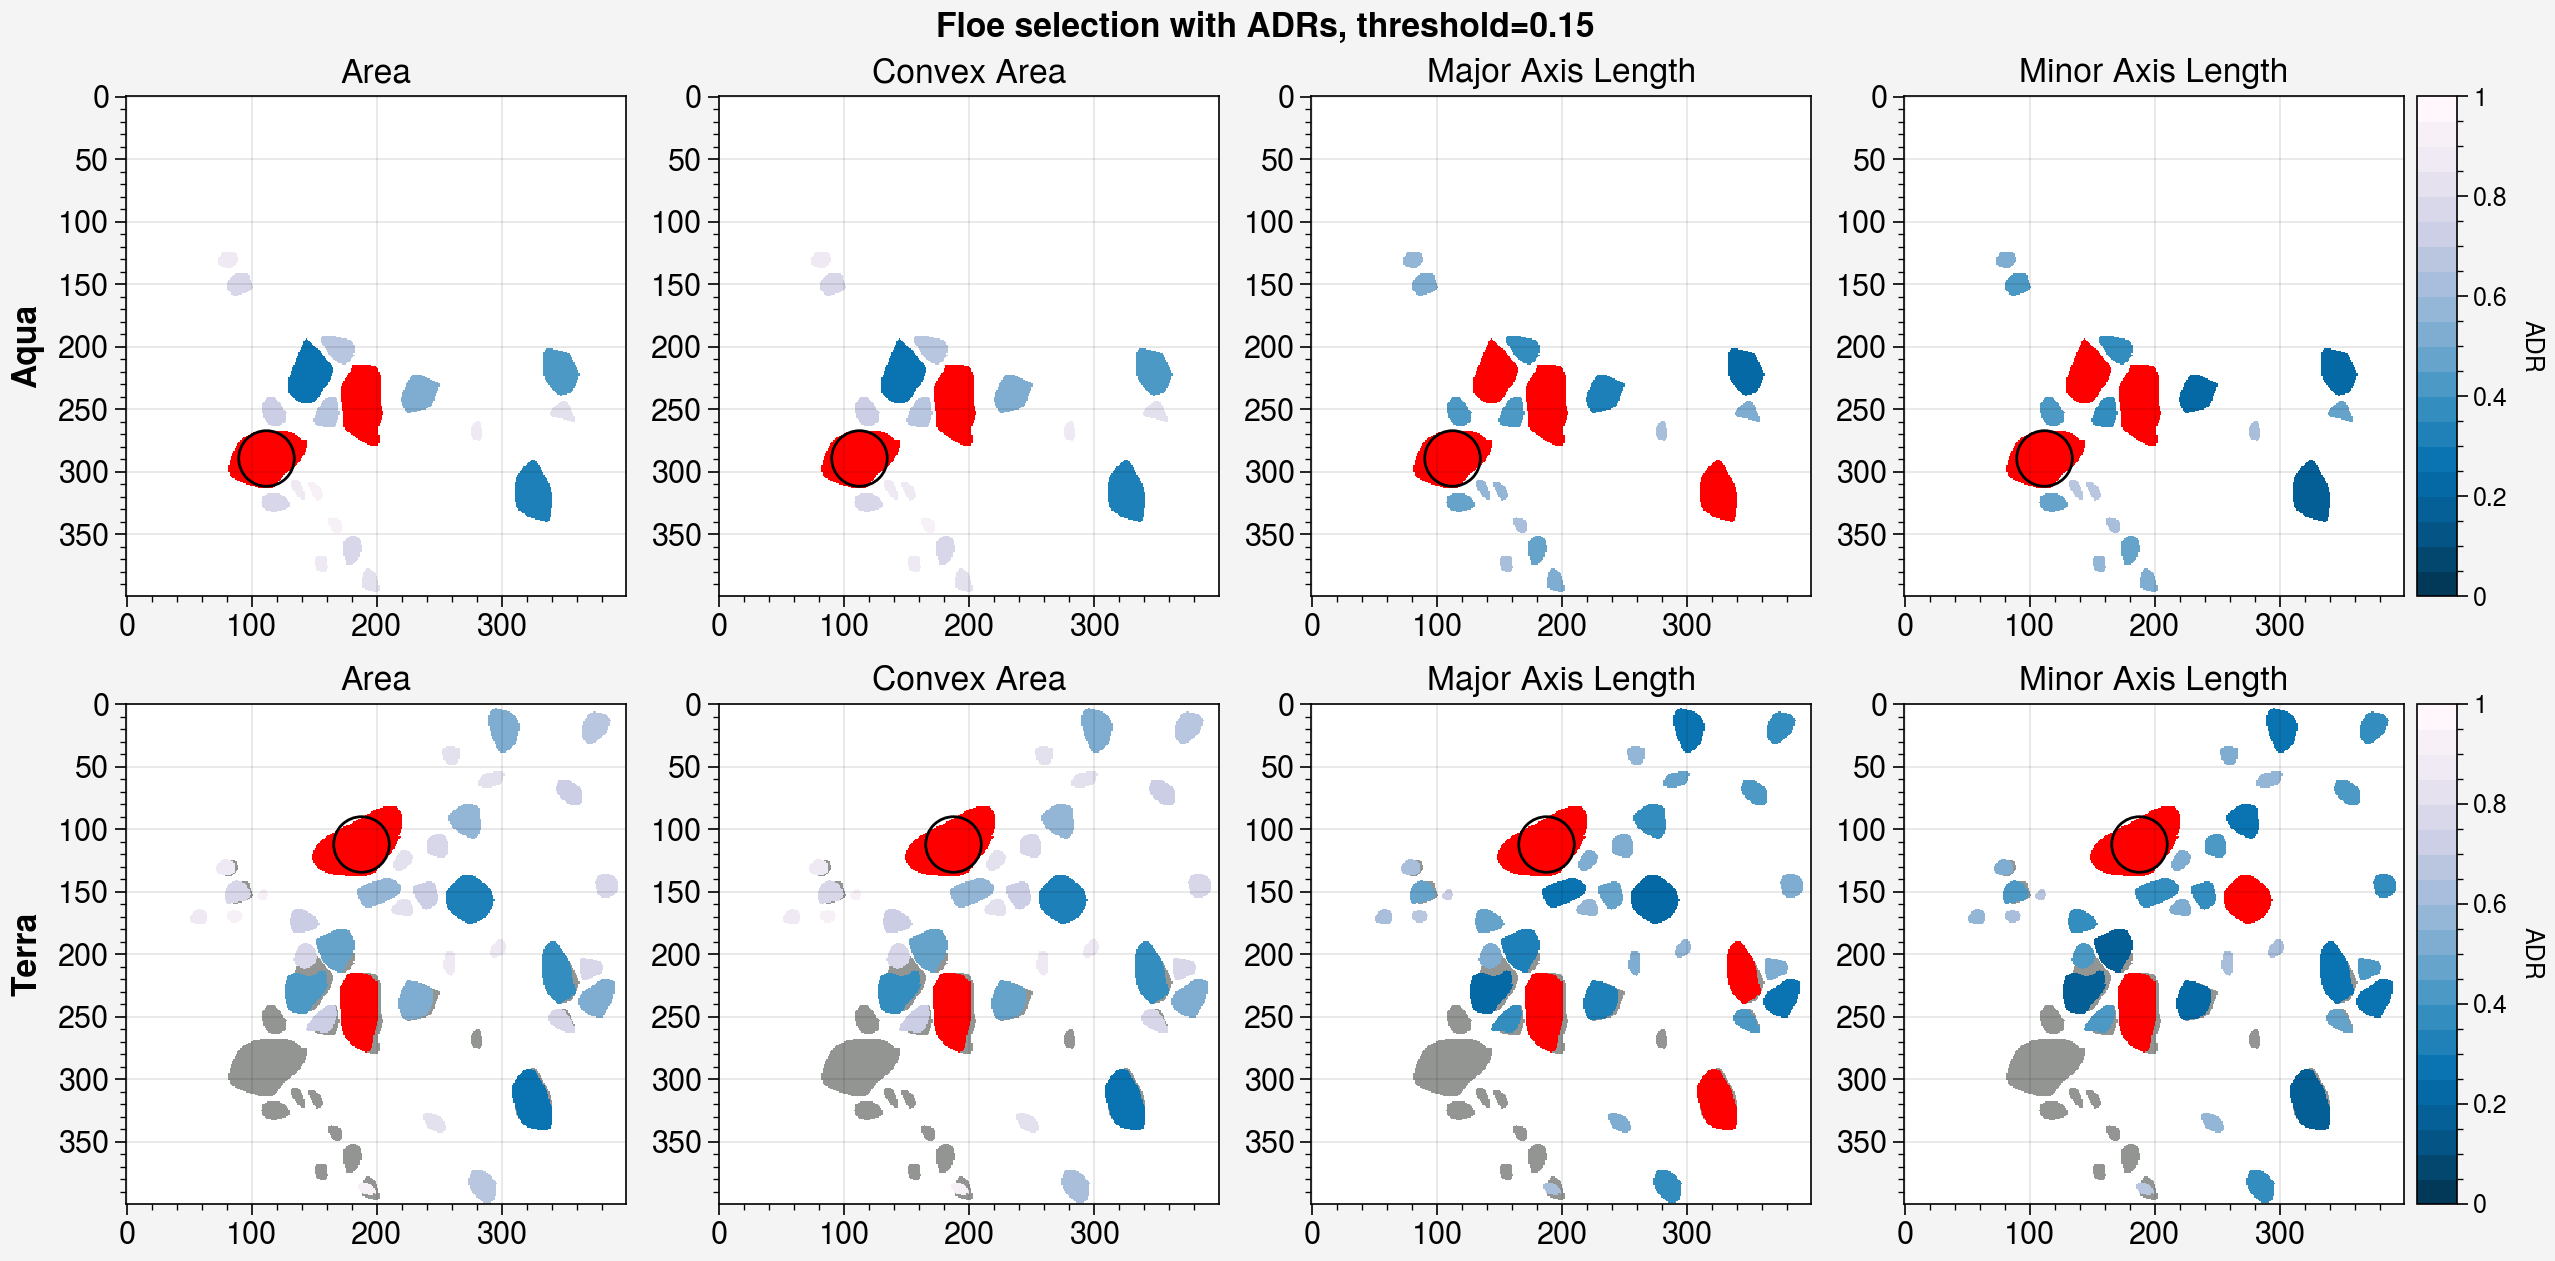

In [402]:
fig, axs = pplt.subplots(nrows=2, ncols=4, share=False)

for ax, title, data in zip(axs[0,:],
                           ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'],
                           [adr_area, adr_convex_area, adr_major_axis_length, adr_minor_axis_length]):
    c0 = ax.imshow(np.ma.masked_array(data, mask=lb_img == 0), cmap='PuBu_r', vmin=0, vmax=1, N=20)
    ax.imshow(np.ma.masked_array(data, mask=(lb_img == 0) |(data > 0.15)), color='r')
    ax.plot(props.loc[label, 'col_centroid'], props.loc[label, 'row_centroid'], m='o', ms=20, edgecolor='k', facecolor='none')
    ax.format(title=title)
    
for ax, title, data in zip(axs[1,:], 
                           ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'],
                           [adr_area0, adr_convex_area0, adr_major_axis_length0, adr_minor_axis_length0]):
    c1 = ax.imshow(np.ma.masked_array(data, mask=lb_img == 0), color='gray')
    c = ax.imshow(np.ma.masked_array(data, mask=lb_img0 == 0), cmap='PuBu_r', vmin=0, vmax=1, N=20)
    

    ax.imshow(np.ma.masked_array(data, mask=(lb_img0 == 0) |(data > 0.15)), color='r')
    for closest_match in np.unique(lb_img0[adr_area0 == np.min(adr_area0[lb_img0 != 0])]):
        if closest_match != 0:
            ax.plot(props0.loc[closest_match, 'col_centroid'], props0.loc[closest_match, 'row_centroid'], m='o', ms=20, edgecolor='k', facecolor='none')
    
    ax.format(title=title)

axs[0,3].colorbar(c, label='ADR')
axs[1,3].colorbar(c0, label='ADR')
axs.format(leftlabels=['Aqua', 'Terra'], suptitle='Floe selection with ADRs, threshold=0.15', fontsize=11)

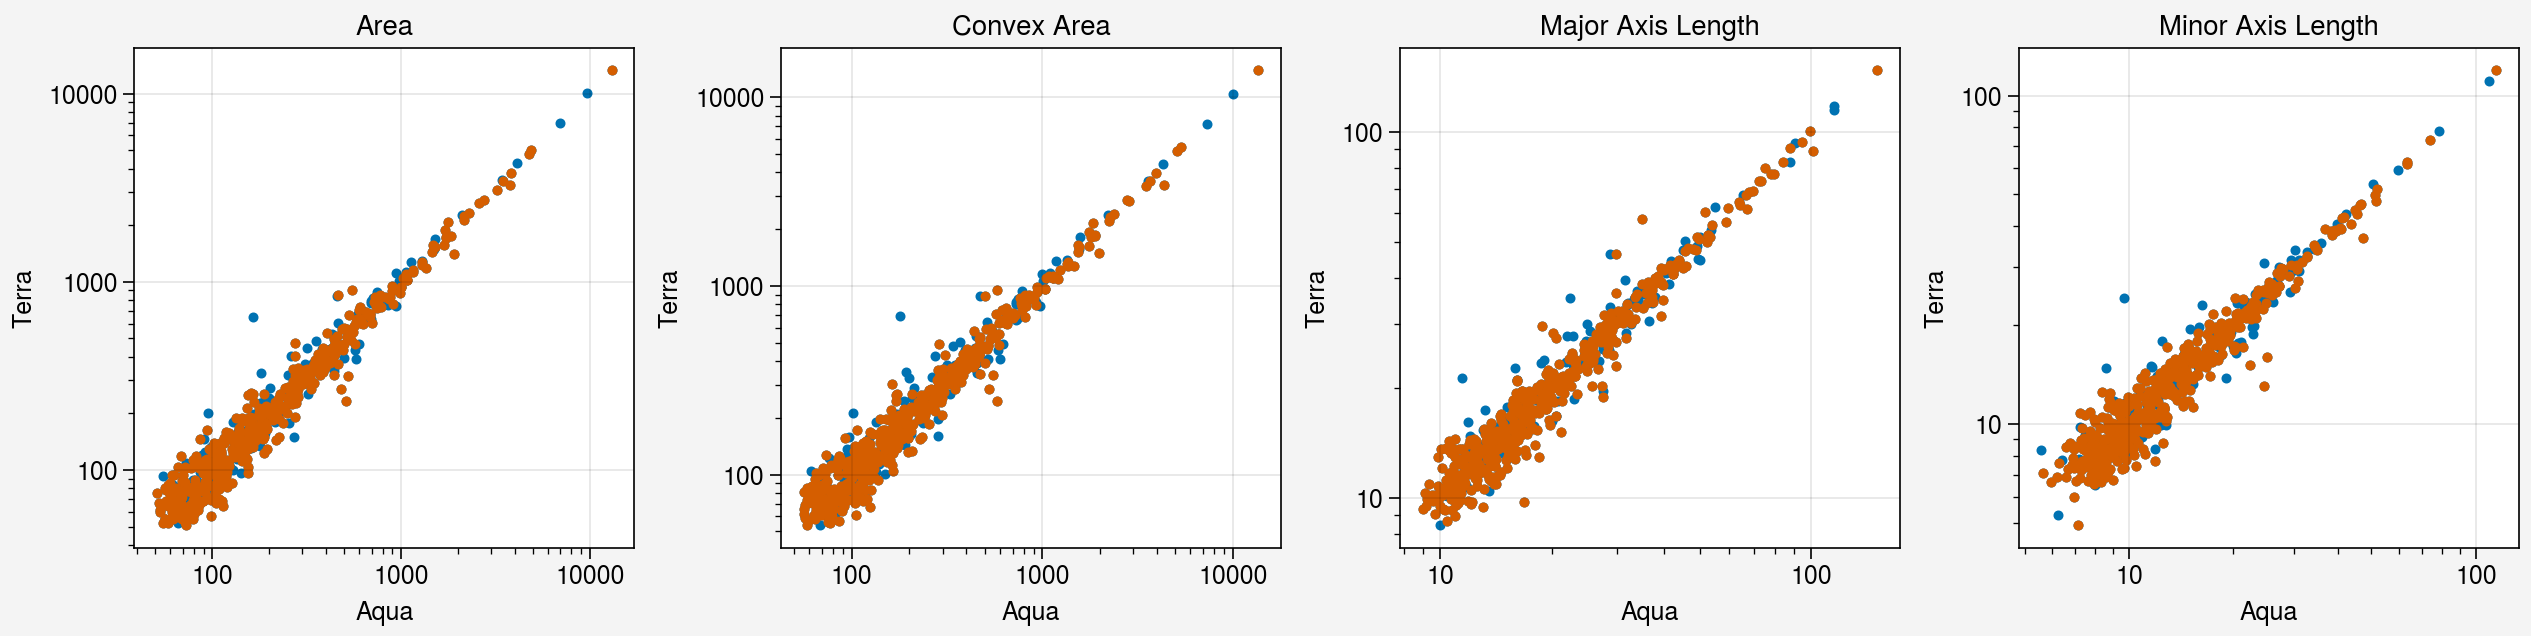

In [137]:
fig, axs = pplt.subplots(ncols=4, share=False)
for ax, var in zip(axs, ['area', 'convex_area', 'major_axis_length', 'minor_axis_length']):
    ax.scatter(df_mg['aqua_' + var],
               df_mg['terra_' + var], m='.')
    ax.scatter(df_mg.loc[df_mg[['aqua_cloud_fraction', 'terra_cloud_fraction']].min(axis=1) < 0.01, 'aqua_' + var],
               df_mg.loc[df_mg[['aqua_cloud_fraction', 'terra_cloud_fraction']].min(axis=1) < 0.01, 'terra_' + var], m='.')
    ax.format(xlabel='Aqua', ylabel='Terra', title=var.replace('_', ' ').title())
axs.format(yscale='log', xscale='log')
fig.save('../figures/scatter_comp_matched_floes.png', dpi=300)

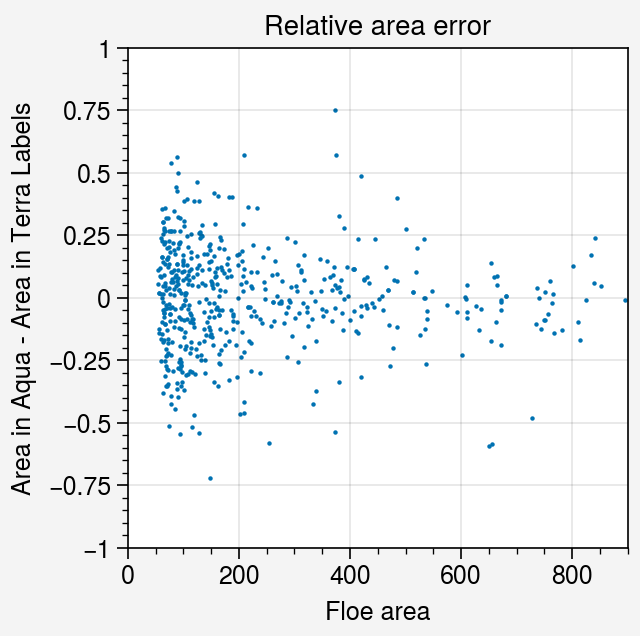

In [143]:
df_mg['area_diff'] = df_mg['aqua_area'] - df_mg['terra_area']
fig, ax = pplt.subplots()
ax.scatter(df_mg.area, df_mg.area_diff/df_mg.area, ms=1)
ax.format(ylim=(-1, 1), xlim=(0, 900), title='Relative area error', xlabel='Floe area', ylabel='Area in Aqua - Area in Terra Labels')



* $\psi\mbox{-}s$ curve correlation
* $Re(X, Y) = \frac{\mbox{area}(X \cap Y)}{\mbox{area}(X)}$
* $SD(X,Y) = \mbox{area}(X \setminus \, Y) \cup \mbox{area}(Y \setminus X)$
* Normalized $SD(X, Y) = SD(X, Y)/\mbox{area}(X)$ (Could also use the mean area of the two floes)

For $Re$ and $SD$, we take the measure between the source floe and the candidate match _after_ rotation. So letting $R_\theta$ be the rotation operator, and considering $X$ the source and $Y$ the candidate match, we compute the measures with $R_\theta Y$ instead of $Y$.

The threshold curve should be a smooth function of area. I suspect that a method such as median + 1.5*IQR would be good to set the threshold, then an interpolant connecting between bins. The result should be insensitive to the area bin size. For the matched floes, need to answer the question of how often true matches are within the same area bins.

With the threshold-based approach used in the algorithm, the best choice of threshold for a measure that increases monotonically with increasing difference between shapes is going to be one that is sufficiently high that true matches are unlikely to be rejected, while sufficiently low that a large number of non-matches are rejected. 

I am working toward the idea of casting this problem in Bayesian terms. Essentially, given a  a pair of objects $f$ and $g$ and collection of similarity measures $\theta(f, g)$ and, what is the probability $P(f = g | \theta(f, g))$?

Bayes theorem is just a shuffling of conditional properties, but may provide a useful framework for the question of floe matching.
$$ P(A | B) = \frac{P(A) P(B | A)}{P(B)}$$
In this case, we have $A$ being the probability that the floes are a true pair, and $B$ is the event of us getting a particular list of similarity measures. Let's think about the other 3 terms.

1. $P(A) = P(f = g)$. This is the prior. This could be 0, if $f$ was not observed in the second image. If we know that $f$ was observed then choosing it at random would happen in $1/n_{floes}$ times. However, we may also have more information: for example, if we had an estimate of the ice velocity field from neighboring floes or from the wind, or from a cross correlation estimate, we might be able to characterize the probability based on location.
3. $P(B | A)$. This is the probability of getting this particular set of similarity measures given that the floes are actually a match. This is the type of probability that we are going to look at in this notebook, and we'll use it to make a first draft of the threshold settings.
4. $P(B)$. This is the probability of a particular set of observations across ALL possible floe pairings. We'll attempt to quantify this using some kind of random pairing between objects.

Other complications:

* We know that the uncertainty in floe properties depends on the size of the floe compared to the resolution of the image. Should the Bayesian evaluation happen separately for each floe category? Or should the floe area be one of the things going into $B$?
* We have a big collection of floe shapes drawn manually. How should the statistics be updated given the types of uncertainties present in the _segmented_ shapes, rather than the ground truth shapes?

## Variation in floe properties under rotation
An experiment was carried out in which objects of at least 50 pixels in area were extracted from manually labeled images. The first tests of this experiment were done with 18 of the labeled images containing a total of 413 floes. Eventually, we can use a random sample of images and set aside some images for testing afterward. Each floe shape was rotated by -45 to 45 degrees in increments of 3 degrees (30 rotations). Each of the similarity measures is calculated with reference to the unrotated floe. 
- TBD: add the Psi-S curve calculation to the test script.
- TBD: develop new rotation function to potentially replace the HolyLab RegisterQD package.

For each similarity metric, we compute the maximum across the rotations.


## Variation in floe properties between non-matching floes
Although an image is available from Aqua and Terra each day, we intentionally select only one image. Thus, we can know with perfect confidence that _no_ pairs of floes are true matches. We then look at all unique pairs of floes (i.e. combinations, not permutations) and compute the similarity metrics. 

## Variation in floe properties between manually matched floes
In this experiment, we examined pairs of Aqua and Terra images. In most cases, the drift is small relative to the size of the floes, as the images are taken near each other in time. We match based on the intersection over union, then visually inspect the matches. For cases with IOU < 0.5, we provide a list of manually approved pairs. Variation in similarity metrics across true pairs lets us see how the apparent floe shapes vary under differences in lighting, angle, and ice compactness, among other factors.

# Rotation experiment results

In [5]:
import pandas as pd
import os
import ultraplot as pplt
import numpy as np

# Define the area bin edges
# bins = np.logspace(1, 4, base=10, num=20)
bins = np.logspace(0.84, 2, base=10, num=20)

#### Load the rotation data ######
# First need to run the julia script rotation_test_floe_shapes_ADR.jl
data = []
for fname in os.listdir('../data/rotation_test/'):
    if '.csv' in fname:
        df = pd.read_csv('../data/rotation_test/' + fname)
        df['case'] = fname.split('-')[0].replace('.csv', '')
        if len(df) > 0:
            data.append(df)
df_all = pd.concat(data)
df_all['floe_id'] = [cn + '_' + str(f).zfill(4) for cn, f in zip(
                                df_all['case'], df_all['floe_id'])]
df_all = df_all.loc[df_all.area > 50]
df_all["L"] = np.sqrt(df_all.area)
comp_columns = ['area', 'convex_area', 'major_axis_length', 'minor_axis_length',
                'adr_area', 'adr_convex_area', 'adr_major_axis_length',
                'adr_minor_axis_length', 'minimum_shape_difference']

df_max = df_all.groupby('floe_id').max()[comp_columns]
df_min = df_all.groupby('floe_id').min()[['psi_s_correlation']]
df_max.columns = df_max.add_prefix('max_', axis=1).columns
df_init = df_all.loc[df_all.rotation==0, ['floe_id', 'case', 'area', 'L', 'convex_area', 'major_axis_length',
       'minor_axis_length']].set_index('floe_id')
df_rotation = pd.merge(df_init, df_max, left_index=True, right_index=True).merge(df_min, left_index=True, right_index=True)

df_rotation['area_bin'] = np.digitize(df_rotation['area'], bins)

In [8]:
df_rotation.head()

,case,area,L,convex_area,major_axis_length,minor_axis_length,max_area,max_convex_area,max_major_axis_length,max_minor_axis_length,max_adr_area,max_adr_convex_area,max_adr_major_axis_length,max_adr_minor_axis_length,max_minimum_shape_difference,psi_s_correlation,area_bin
floe_id,,,,,,,,,,,,,,,,,
148_0001,148,527.0,22.956481,549.0,31.873853,21.551099,531.0,575.0,32.034467,21.882447,0.005725,0.023132,0.004366,0.007629,15.0,0.977,20
148_0002,148,324.0,18.000000,336.0,23.191872,17.868805,330.0,353.0,23.543020,18.173154,0.009174,0.024673,0.007514,0.009974,8.0,0.981,20
148_0003,148,291.0,17.058722,301.0,26.037026,14.516496,298.0,320.0,26.431755,14.746486,0.011885,0.030596,0.007523,0.007859,11.0,0.973,20
148_0004,148,682.0,26.115130,701.0,45.102189,19.391891,685.0,735.0,45.518202,19.575527,0.004418,0.023677,0.005094,0.004713,16.0,0.975,20
148_0005,148,425.0,20.615528,444.0,34.776696,16.079807,428.0,470.0,35.050836,16.235314,0.009501,0.028446,0.007760,0.004812,11.0,0.972,20


## Divide into test/train datasets

In [18]:
# Divide into testing and training datasets
df_testtrain = pd.read_csv('../data/validation_dataset_testtrain_split.csv').rename({'Unnamed: 0': 'case'}, axis=1)
df_testtrain['case_number'] = [str(x).zfill(3) for x in df_testtrain['case_number']]
training_idx = df_testtrain.loc[df_testtrain.satellite == 'aqua', ['case_number', 'training']].set_index('case_number')
df_rotation['training'] = training_idx.loc[df_rotation['case']].values

# training_idx = df_rotation.sample(frac=2/3, random_state=4203).sort_index().index
# df_rotation['training'] = False
# df_rotation.loc[training_idx, 'training'] = True

In [23]:
# could make this a function
df = df_rotation.copy()

bin_length_count = df[['length_bin', 'L']].groupby('length_bin').mean()
bin_length_count['count'] = df[['length_bin', 'L']].groupby('length_bin').count()['L']

fig, ax = pplt.subplots(width=6, height=3)
h = []
for var, color, offset in zip(['max_adr_area', 'max_adr_convex_area',
                       'max_adr_major_axis_length', 'max_adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='length_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_length_count['count'] > 20]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(4.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in bin_length_count.L.round().values.squeeze()], xrotation=0,
         title='Maximum ADR under rotation', xlabel='Bin-average floe length scale (pixels)', ylabel='ADR',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/maximum_adr_rotation_boxplot.png', dpi=300)

KeyError: "['length_bin'] not in index"

array([  6.91830971,   7.96255842,   9.16442588,  10.54770305,
        12.13977189,  13.97214738,  16.08110137,  18.50838058,
        21.30203298,  24.51735888,  28.21800563,  32.47722749,
        37.3793357 ,  43.02136745,  49.51500669,  56.98879494,
        65.59067575,  75.49092326,  86.88551275, 100.        ])

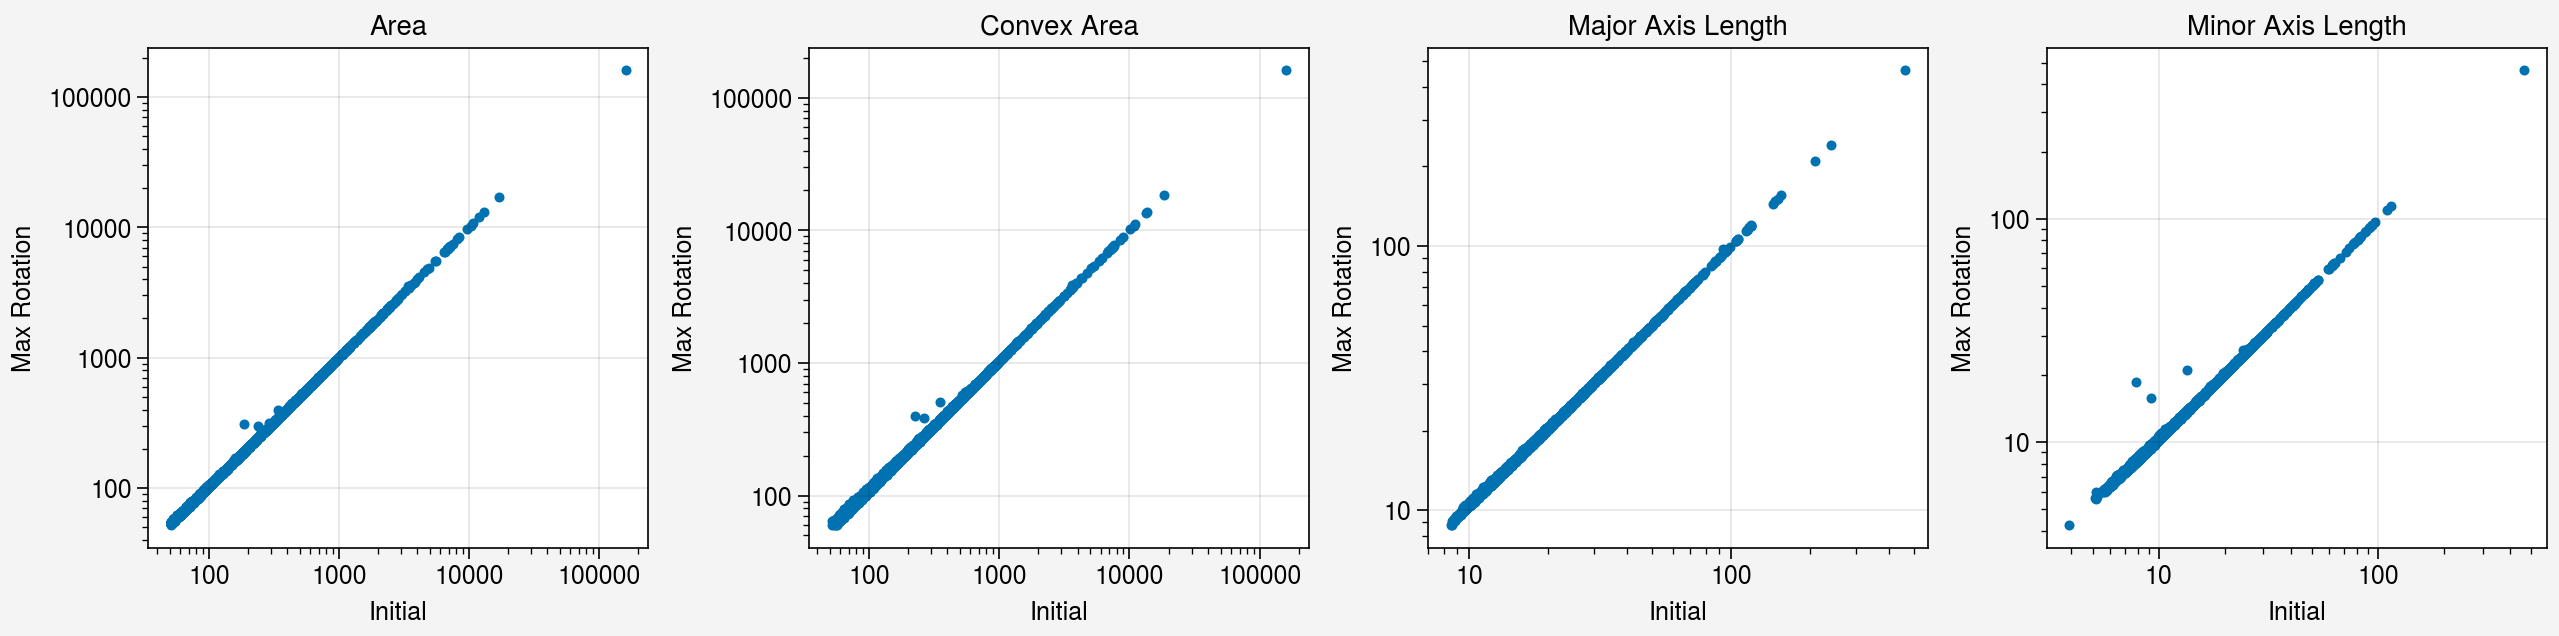

In [24]:
fig, axs = pplt.subplots(ncols=4, share=False)
for ax, var in zip(axs, ['area', 'convex_area', 'major_axis_length', 'minor_axis_length']):
    ax.scatter(df_rotation[var],
               df_rotation['max_' + var], m='.')
    ax.format(xlabel='Initial', ylabel='Max Rotation', title=var.replace('_', ' ').title(), xscale='log', yscale='log')
fig.save('../figures/scatter_comp_rotation_floes.png', dpi=300)

In [30]:
# TBD later: check out the shapes that have large errors. They could have errors in the labels.
var = 'area'
norm_diff = (df_rotation[var] - df_rotation['max_' + var])/(df_rotation[var])
df_rotation.loc[norm_diff == norm_diff.min()]

,case,area,L,convex_area,major_axis_length,minor_axis_length,max_area,max_convex_area,max_major_axis_length,max_minor_axis_length,max_adr_area,max_adr_convex_area,max_adr_major_axis_length,max_adr_minor_axis_length,max_minimum_shape_difference,psi_s_correlation,area_bin,training
floe_id,,,,,,,,,,,,,,,,,,
109_0012,109,185.0,13.601471,228.0,32.47432,7.897144,310.0,398.0,32.971813,18.632742,0.252525,0.271565,0.198214,0.404661,16.0,0.594,20,True


Estimating the upper bound implied by rotation uncertainty

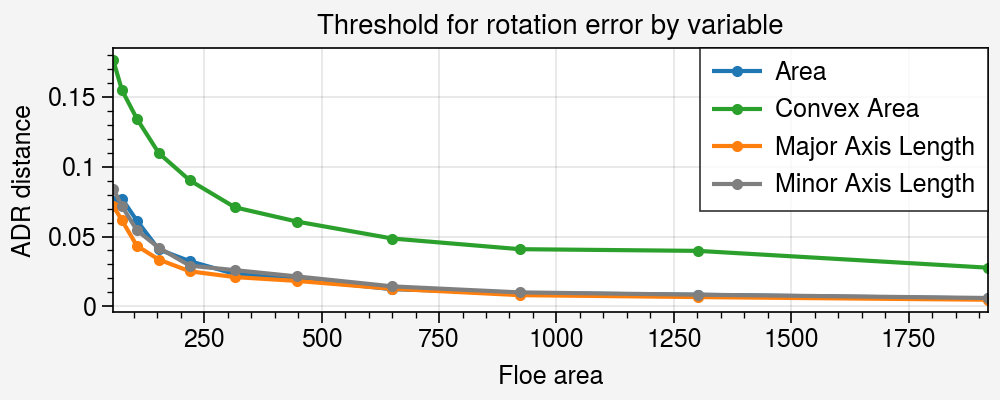

In [28]:
var = 'max_adr_area'
# standard log space bins
bins = np.logspace(1, 4, base=10, num=20)
df['area_bin'] = np.digitize(df['area'], bins)
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

df_filtered = df.groupby('area_bin').filter(lambda x: len(x) > 30)
thresh_results = {}
fig, ax = pplt.subplots(width=5, height=2)
h = []
for var, color in zip(['max_adr_area', 'max_adr_convex_area',
                       'max_adr_major_axis_length', 'max_adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):

    q = df_filtered[['area_bin', var]].groupby('area_bin').quantile([0.99, 0.75, 0.5, 0.25]).reset_index()
    q.rename({'level_1': 'percentile'}, axis=1, inplace=True)
    q = q.pivot_table(index='area_bin', columns='percentile', values=var)
    iqr = q[0.75] - q[0.25]
    thresh = q[0.5] + 1.5*iqr
    thresh_results[var] = pd.Series(thresh.values, index=bin_area_count.loc[thresh.index, 'area'].values)
    
    h.append(ax.plot(bin_area_count.loc[thresh.index, 'area'].values, thresh.values, marker='.', color=color, label=var))
ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
ax.format(title='Threshold for rotation error by variable', ylabel='ADR distance', xlabel='Floe area')

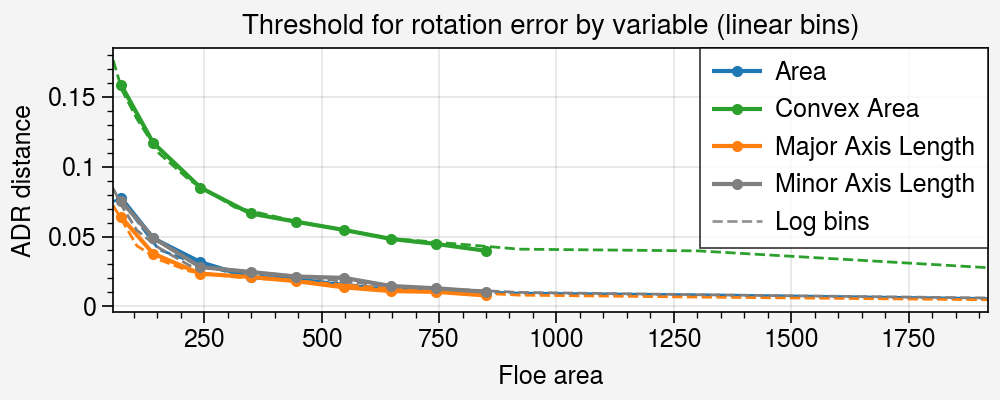

In [29]:
var = 'max_adr_area'
# standard log space bins
bins = np.arange(0, 10000, 100)
df['area_bin'] = np.digitize(df['area'], bins)
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

df_filtered = df.groupby('area_bin').filter(lambda x: len(x) > 30)

fig, ax = pplt.subplots(width=5, height=2)
h = []
for var, color in zip(['max_adr_area', 'max_adr_convex_area',
                       'max_adr_major_axis_length', 'max_adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):

    q = df_filtered[['area_bin', var]].groupby('area_bin').quantile([0.99, 0.75, 0.5, 0.25]).reset_index()
    q.rename({'level_1': 'percentile'}, axis=1, inplace=True)
    q = q.pivot_table(index='area_bin', columns='percentile', values=var)
    iqr = q[0.75] - q[0.25]
    thresh = q[0.5] + 1.5*iqr
    
    
    h.append(ax.plot(bin_area_count.loc[thresh.index, 'area'].values, thresh.values, marker='.', color=color, label=var))
    ax.plot(thresh_results[var], color=color, label='', ls='--', lw=1)
h.append(ax.plot([],[], ls='--', lw=1, color='gray'))
ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length', 'Log bins'], ncols=1)
ax.format(title='Threshold for rotation error by variable (linear bins)', ylabel='ADR distance', xlabel='Floe area')

# Matched pairs experiment

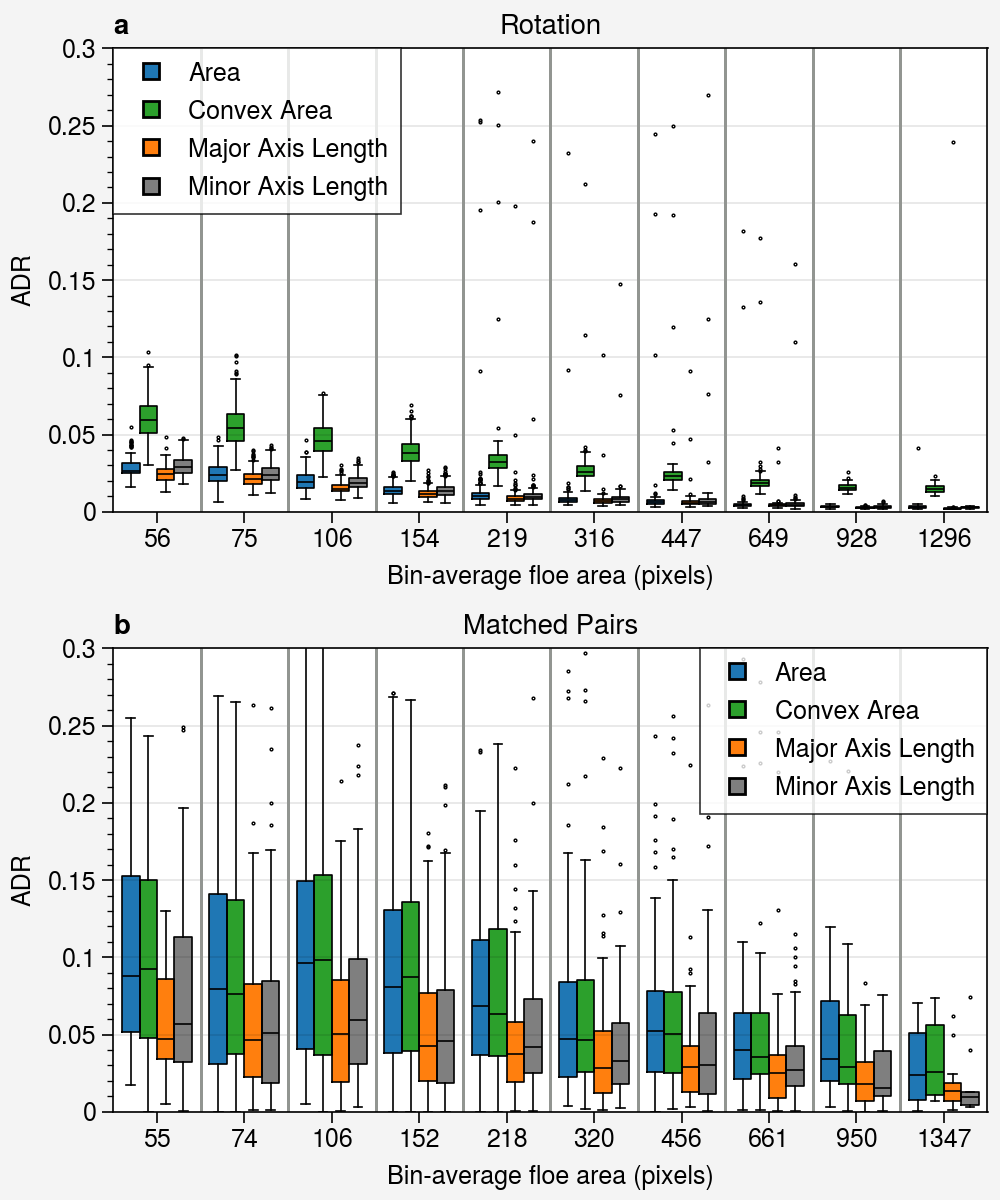

In [74]:
%run ../scripts/plot_adr_thresholds.py

In [ ]:
df_aqua_props = []
for file in os.listdir('../data/floe_property_tables/aqua/'):
    if 'csv' in file:
        df_temp = pd.read_csv('../data/floe_property_tables/aqua/' + file).loc[:, ['label', 'cloud_fraction']]
        df_temp['case'] = file.split('-')[0]
        df_aqua_props.append(df_temp)
df_aqua_props = pd.concat(df_aqua_props)
df_aqua_props['label'] = df_aqua_props['label'].astype(int)
df_aqua_props.rename({'label': 'aqua_label', 'cloud_fraction': 'aqua_cloud_fraction'}, axis=1, inplace=True)

df_terra_props = []
for file in os.listdir('../data/floe_property_tables/terra/'):
    if 'csv' in file:
        df_temp = pd.read_csv('../data/floe_property_tables/terra/' + file).loc[:, ['label', 'cloud_fraction']]
        df_temp['case'] = file.split('-')[0]
        df_terra_props.append(df_temp)
df_terra_props = pd.concat(df_terra_props)
df_terra_props['label'] = df_terra_props['label'].astype(int)
df_terra_props.rename({'label': 'terra_label', 'cloud_fraction': 'terra_cloud_fraction'}, axis=1, inplace=True)

# rename to get the aqua cloud fraction
df_matched = df_matched.merge(
    df_aqua_props, left_on=['case', 'aqua_label'], right_on=['case', 'aqua_label']).merge(
    df_terra_props, left_on=['case', 'terra_label'], right_on=['case', 'terra_label'])

# Divide into testing and training datasets
df_testtrain = pd.read_csv('../data/validation_dataset_testtrain_split.csv').rename({'Unnamed: 0': 'case'}, axis=1)
df_testtrain['case_number'] = [str(x).zfill(3) for x in df_testtrain['case_number']]
training_idx = df_testtrain.loc[df_testtrain.satellite == 'aqua', ['case_number', 'training']].set_index('case_number')
df_matched['training'] = training_idx.loc[df_matched['case']].values


In [63]:
# error with finding the levels for the cloudmask. 


In [79]:
df_matched.groupby('training').count()
df_mg = df_matched.loc[df_matched.training]

In [80]:
df_mg.columns

Index(['aqua_label', 'terra_label', 'aqua_area', 'aqua_convex_area',
       'aqua_major_axis_length', 'aqua_minor_axis_length', 'aqua_perimeter',
       'aqua_perimeter_crofton', 'terra_area', 'terra_convex_area',
       'terra_major_axis_length', 'terra_minor_axis_length', 'terra_perimeter',
       'terra_perimeter_crofton', 'adr_area', 'adr_convex_area',
       'adr_major_axis_length', 'adr_minor_axis_length', 'rotation_estimated',
       'minimum_shape_difference', 'psi_s_correlation', 'case', 'floe_id',
       'area', 'perimeter', 'normalized_shape_difference', 'L', 'area_bin',
       'training', 'aqua_cloud_fraction', 'terra_cloud_fraction'],
      dtype='object')

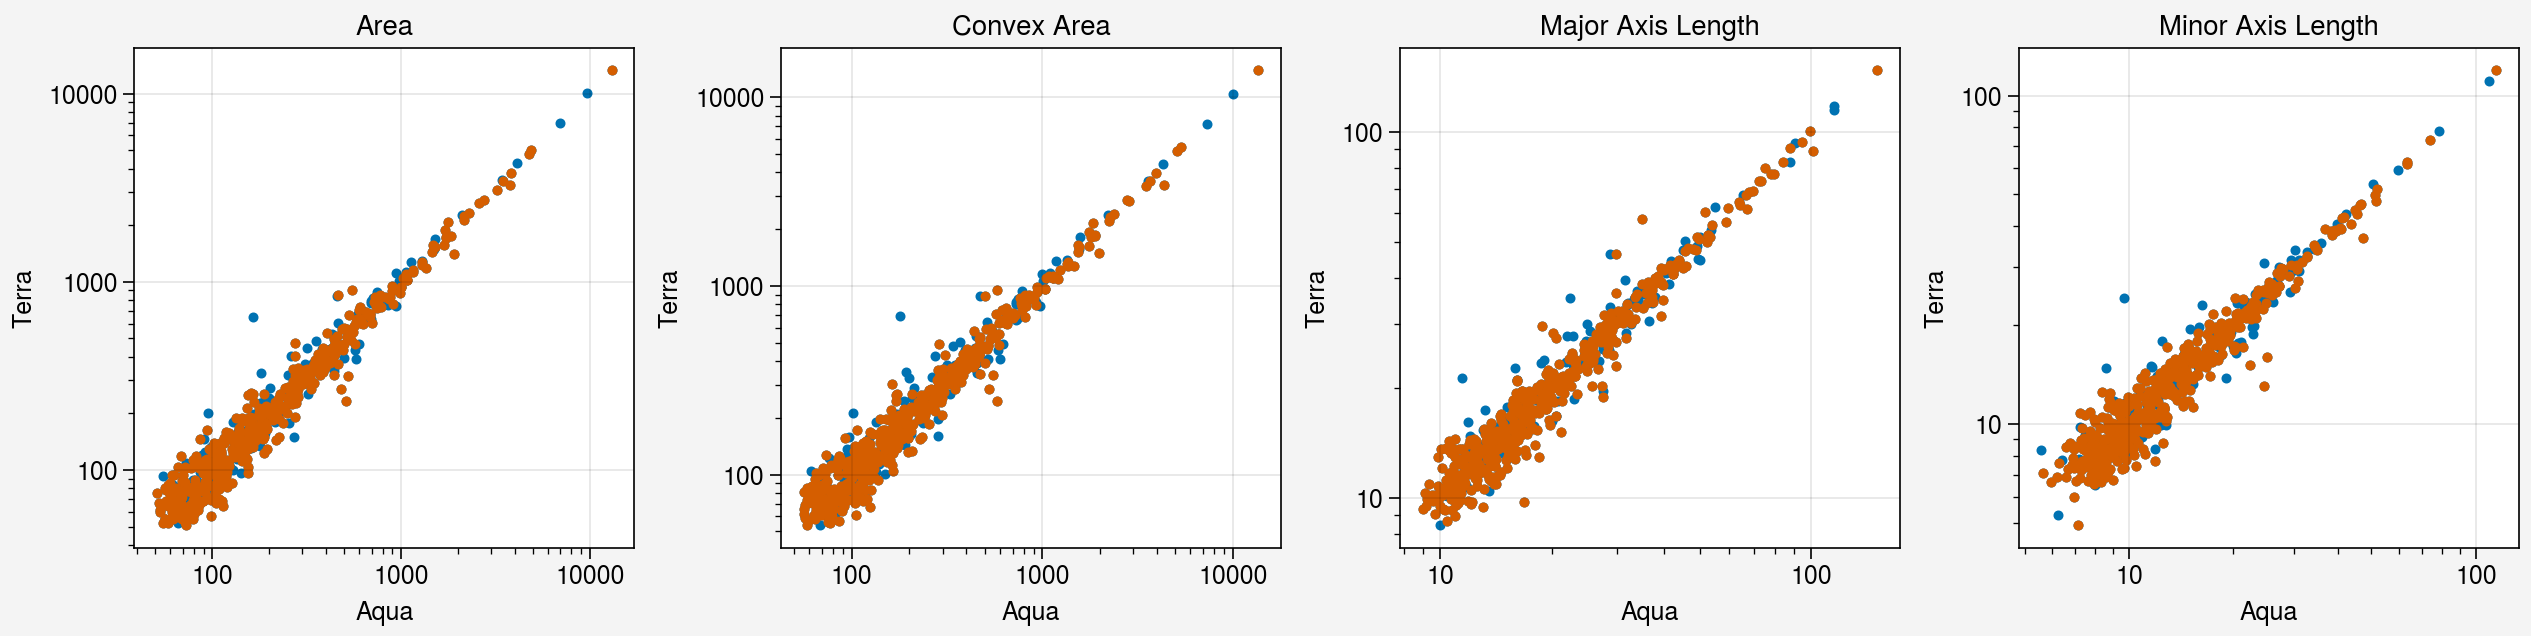

In [85]:
fig, axs = pplt.subplots(ncols=4, share=False)
for ax, var in zip(axs, ['area', 'convex_area', 'major_axis_length', 'minor_axis_length']):
    ax.scatter(df_mg['aqua_' + var],
               df_mg['terra_' + var], m='.')
    ax.scatter(df_mg.loc[df_mg[['aqua_cloud_fraction', 'terra_cloud_fraction']].min(axis=1) < 0.01, 'aqua_' + var],
               df_mg.loc[df_mg[['aqua_cloud_fraction', 'terra_cloud_fraction']].min(axis=1) < 0.01, 'terra_' + var], m='.')
    ax.format(xlabel='Aqua', ylabel='Terra', title=var.replace('_', ' ').title())
axs.format(yscale='log', xscale='log')
fig.save('../figures/scatter_comp_matched_floes.png', dpi=300)

In [38]:
df_merged['adr_area'] = 2*np.abs(df_merged['area_aqua'] - df_merged['area_terra'])/(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['adr_major_axis_length'] = 2*np.abs(df_merged['axis_major_length_aqua'] - df_merged['axis_major_length_terra'])/(df_merged['axis_major_length_aqua'] + df_merged['axis_major_length_terra'])
df_merged['adr_minor_axis_length'] = 2*np.abs(df_merged['axis_minor_length_aqua'] - df_merged['axis_minor_length_terra'])/(df_merged['axis_minor_length_aqua'] + df_merged['axis_minor_length_terra'])
df_merged['adr_convex_area'] = 2*np.abs(df_merged['convex_area_aqua'] - df_merged['convex_area_terra'])/(df_merged['convex_area_aqua'] + df_merged['convex_area_terra'])

bins = np.logspace(1, 4, base=10, num=20)

df_merged['area'] = 1/2*(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['L'] = np.sqrt(df_merged['area'])
df_merged['length_bin'] = np.digitize(df_merged['L'], bins)
# df_merged['area_bin'] = np.digitize(df_merged['area'], bins)
df_merged = df_merged.loc[df_merged.area > 50].copy()
merged_bin_length_count = df_merged[['length_bin', 'L']].groupby('length_bin').mean()
merged_bin_length_count['count'] = df_merged[['length_bin', 'L']].groupby('length_bin').count()['L']


The lower bins may be too narrow for the randomization experiment: many floe pairs fall into different bins. If I want to mimic the true pairings, what's the best strategy? 

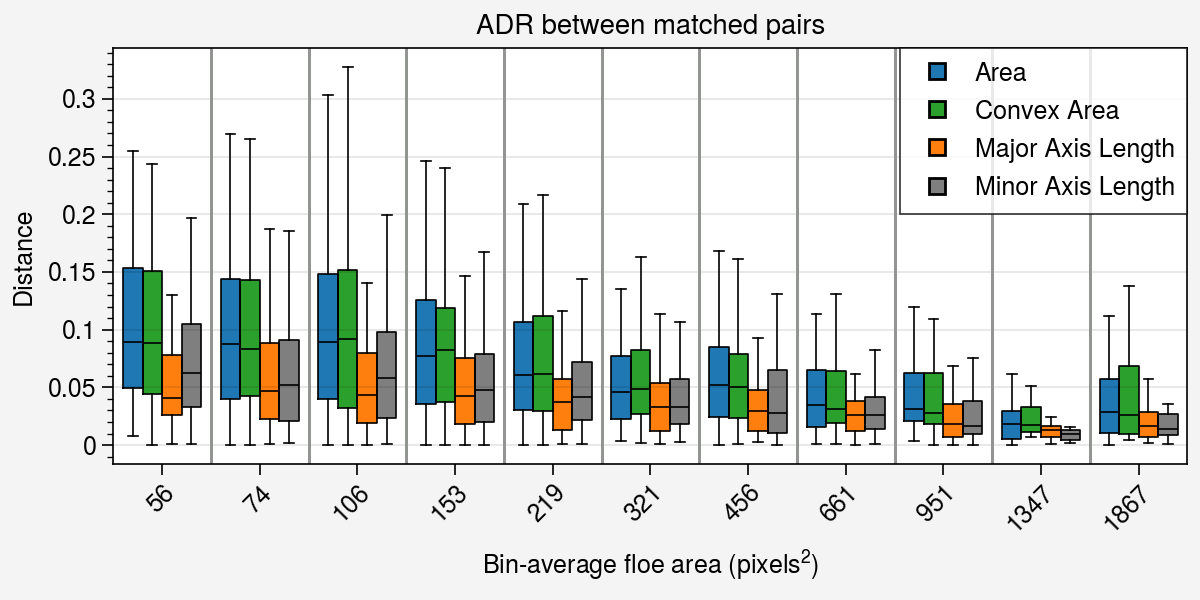

In [137]:
fig, ax = pplt.subplots(width=6, height=3)
h = []
df = df_merged.copy()
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']
for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    # bin_area_ave = df[['area_bin', 'area']].groupby('area_bin').mean()
    plot_data = plot_data.loc[:, bin_area_count['count'] > 10]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(4.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in bin_area_count.area.round().values.squeeze()], xrotation=45,
         title='ADR between matched pairs', xlabel='Bin-average floe area (pixels$^2$)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
# fig.save('../figures/../figures/adr_matched_boxplot.png', dpi=300)

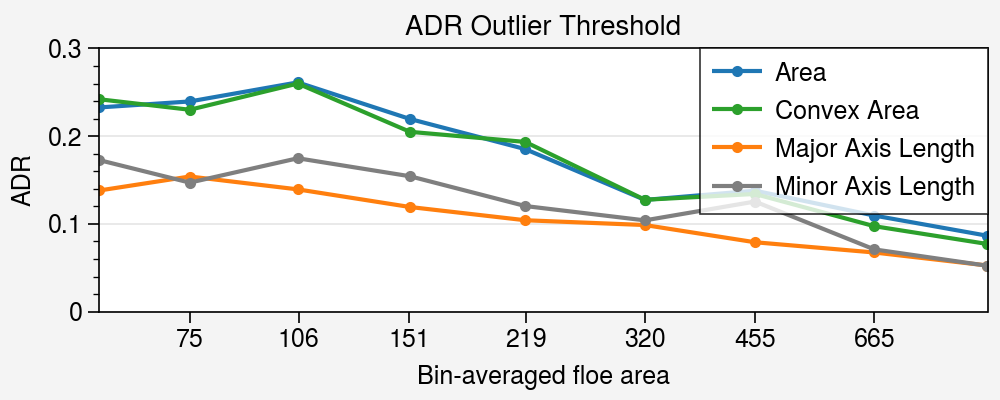

In [136]:
var = 'max_adr_area'
# standard log space bins
bins = np.logspace(1, 4, base=10, num=20)
df = df_merged.loc[df_merged.training].copy()
df['area_bin'] = np.digitize(df['area'], bins)
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

df_filtered = df.groupby('area_bin').filter(lambda x: len(x) > 20)
thresh_results = {}
fig, ax = pplt.subplots(width=5, height=2)
h = []
for var, color in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):

    q = df_filtered[['area_bin', var]].groupby('area_bin').quantile([0.99, 0.75, 0.5, 0.25]).reset_index()
    q.rename({'level_1': 'percentile'}, axis=1, inplace=True)
    q = q.pivot_table(index='area_bin', columns='percentile', values=var)
    iqr = q[0.75] - q[0.25]
    thresh = q[0.5] + 1.5*iqr
    thresh_results[var] = pd.Series(thresh.values, index=bin_area_count.loc[thresh.index, 'area'].values)
    
    h.append(ax.plot(bin_area_count.loc[thresh.index, 'area'].values, thresh.values, marker='.', color=color, label=var))

    # fitting a function
    
    # for xc in x[:-1]:
    #     ax.axvline(xc + 0.5, lw=1, color='gray')

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
ax.format(title='ADR Outlier Threshold', ylabel='ADR', xlabel='Bin-averaged floe area')
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=bin_area_count.area.round().values.squeeze(),
          # xformatter=[str(int(x)) for x in bin_area_count.area.round().values.squeeze()], xrotation=45,
         # title='ADR between matched pairs', xlabel='Bin-average floe area (pixels$^2$)', ylabel='Distance',
         xgrid=False, xscale='log', ylim=(0, 0.3))



I looked at fitting an exponential function, and it looks okay but is potentially overkill here. The ADR stuff is all pretty basic and isn't enough to filter out poor fits on its own. I'm thinking that we set a threshold for the areas and for the axes, and it's piecewise linear. We compute the upper outlier limit as the median plus 1.5 times the interquartile range. The 


In [128]:
df_filtered

,Unnamed: 0,aqua_label,terra_label,area_aqua,area_terra,joint_area,iou,r_aqua,c_aqua,r_terra,...,axis_minor_length_terra,convex_area_terra,adr_area,adr_major_axis_length,adr_minor_axis_length,adr_convex_area,area,L,area_bin,training
0,5,29.0,5.0,202.0,219.0,47.0,0.125668,183.594059,29.970297,192.872146,...,14.884422,232.0,0.040380,0.002224,0.043708,0.031111,210.5,14.508618,9,True
1,1,2.0,1.0,76.0,69.0,65.0,0.812500,10.276316,98.000000,10.710145,...,8.238917,73.0,0.048276,0.033205,0.016507,0.064103,72.5,8.514693,6,True
2,0,1.0,2.0,57.0,46.0,46.0,0.807018,8.807018,150.315789,9.130435,...,6.804873,48.0,0.106796,0.024413,0.088096,0.102804,51.5,7.176350,5,False
3,2,3.0,5.0,1059.0,964.0,936.0,0.861086,29.083097,356.373938,28.447095,...,32.595499,999.0,0.046960,0.035432,0.015563,0.047664,1011.5,31.804088,13,True
4,3,4.0,6.0,91.0,70.0,68.0,0.731183,20.241758,243.527473,19.828571,...,7.623016,72.0,0.130435,0.072072,0.060158,0.137725,80.5,8.972179,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8,9.0,10.0,407.0,536.0,343.0,0.571667,188.896806,277.631450,186.283582,...,18.958936,580.0,0.136797,0.037911,0.091159,0.140610,471.5,21.714051,11,True
1110,11,12.0,12.0,700.0,608.0,540.0,0.703125,314.242857,54.197143,312.761513,...,17.187424,681.0,0.070336,0.017241,0.105804,0.086519,654.0,25.573424,12,True
1111,12,13.0,13.0,109.0,117.0,69.0,0.439490,334.669725,95.642202,333.564103,...,8.151744,136.0,0.035398,0.050812,0.006092,0.058366,113.0,10.630146,7,True
1112,0,2.0,3.0,129.0,181.0,126.0,0.684783,374.666667,362.224806,375.574586,...,15.000046,191.0,0.167742,0.047804,0.127284,0.175385,155.0,12.449900,8,False


In [ ]:
# To decide
# Form of the threshold function
# How to implement in Julia
# Measure of success: fraction of false negatives in the testing data (i.e., matched pairs that are rejected).
def area_adr_threshold_function(area):
    

def axis_adr_threshold_function():
    


In [125]:
var = 'adr_area'
q = df_filtered[['area_bin', var]].groupby('area_bin').quantile([0.99, 0.75, 0.5, 0.25]).reset_index()
q.rename({'level_1': 'percentile'}, axis=1, inplace=True)
q = q.pivot_table(index='area_bin', columns='percentile', values=var)
iqr = q[0.75] - q[0.25]
thresh = q[0.5] + 1.5*iqr
thresh_results[var] = pd.Series(thresh.values, index=bin_area_count.loc[thresh.index, 'area'].values)


In [126]:
from numpy.polynomial import Polynomial

# Fitting y = A exp(Bx) --> log y = log A + Bx
x = bin_area_count.loc[thresh.index, 'area'].values
y = np.log(thresh.values)
polyfit_results = Polynomial.fit(x, y, deg=1).convert(domain=(-1, 1))
a, b = polyfit_results.coef
A = np.exp(a)
B = b
test = lambda area: A*np.exp(B*area)
print('y = {a}exp({b}x)'.format(a=np.round(A, 3), b=np.round(B, 4)))

y = 0.246exp(-0.0012x)


<a list of 1 Line2D objects>

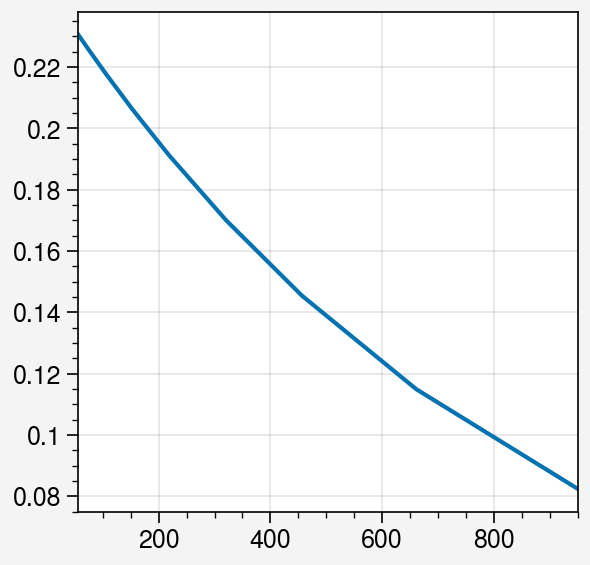

In [127]:
fig, ax = pplt.subplots()
ax.plot(x, test(x))

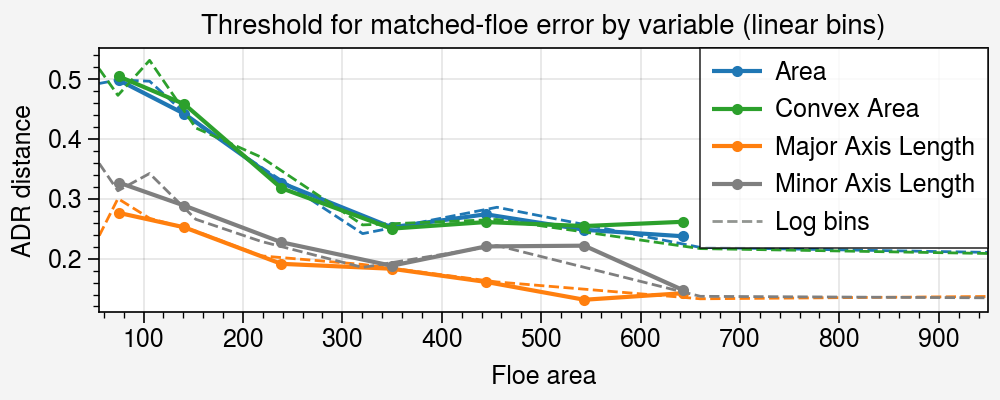

In [38]:
var = 'max_adr_area'
# standard log space bins
bins = np.arange(0, 10000, 100)
df = df_merged.copy()
df['area_bin'] = np.digitize(df['area'], bins)
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

df_filtered = df.groupby('area_bin').filter(lambda x: len(x) > 30)

fig, ax = pplt.subplots(width=5, height=2)
h = []
for var, color in zip(['adr_area', 'adr_convex_area',
                       'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):

    q = df_filtered[['area_bin', var]].groupby('area_bin').quantile([0.99, 0.75, 0.5, 0.25]).reset_index()
    q.rename({'level_1': 'percentile'}, axis=1, inplace=True)
    q = q.pivot_table(index='area_bin', columns='percentile', values=var)
    iqr = q[0.75] - q[0.25]
    thresh = q[0.5] + 1.5*iqr
    
    
    h.append(ax.plot(bin_area_count.loc[thresh.index, 'area'].values, thresh.values, marker='.', color=color, label=var))
    ax.plot(thresh_results[var], color=color, label='', ls='--', lw=1)
h.append(ax.plot([],[], ls='--', lw=1, color='gray'))
ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length', 'Log bins'], ncols=1)
ax.format(title='Threshold for matched-floe error by variable (linear bins)', ylabel='ADR distance', xlabel='Floe area')

# Unmatched pairs experiment
We test the background variability of the floe metrics by looking at pairs that are known not to be matches. We select all the Aqua image, then, within each area bin, we find the full list of combinations (possible pairs, no repeats, order doesn't matter), and draw a sample of 1000 of each of the random pairs. Then, we compute the ADR between each pair.

In [39]:
import itertools
import numpy as np

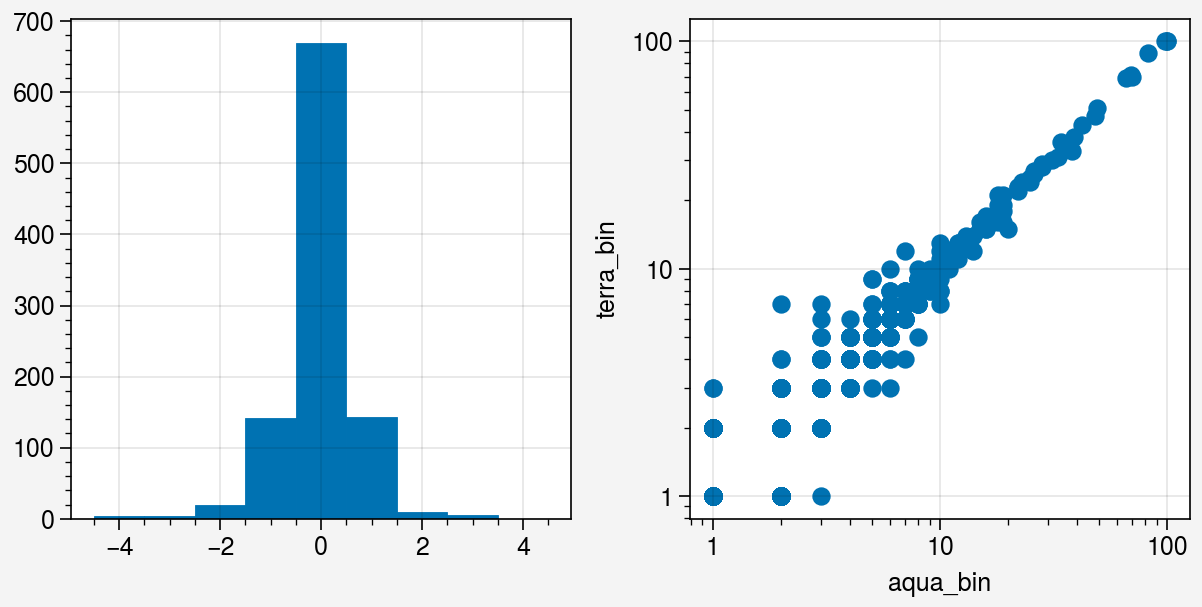

In [40]:
df_merged['aqua_bin'] = np.digitize(df_merged['area_aqua'], bins)
df_merged['terra_bin'] = np.digitize(df_merged['area_terra'], bins)

fig, ax = pplt.subplots(ncols=2, share=False)
ax[0].hist(df_merged['aqua_bin'] - df_merged['terra_bin'], bins=np.arange(-4.5, 4.6, 1))
ax[1].scatter(df_merged['aqua_bin'], df_merged['terra_bin'])
ax[1].format(yscale='log', xscale='log')

In [41]:
df_aqua['floe_id'] = [cn + '_' + str(int(lb)).zfill(3) for cn, lb in zip(df_aqua['case_number'],
                                                                         df_aqua['label'])]
df_aqua.set_index('floe_id', drop=True, inplace=True)
bins = np.logspace(1, 4, base=10, num=20)
df_aqua['area_bins'] = np.digitize(df_aqua['area'], bins)

In [42]:
# Method 1: keep it within bins
def adr(d1, d2, v):
    return 2*np.abs(d1[v].values - d2[v].values)/(d1[v].values + d2[v].values)

results = []
for bn, data in df_aqua.groupby('area_bins'):
    if data.area.min() > 50:
        if len(data) > 20:
            c = itertools.combinations(data.index, 2)
            rng = np.random.default_rng(seed=5 + bn)
            n = 1000
            pairs = rng.choice(list(c), n)
            f = pairs[:,0]
            g = pairs[:, 1]
            results.append(
                pd.DataFrame(
                    {'adr_area': np.round(adr(data.loc[f], data.loc[g], 'area'), 4),
                     'adr_convex_area':  np.round(adr(data.loc[f], data.loc[g], 'convex_area'), 4),
                     'adr_major_axis_length':  np.round(adr(data.loc[f], data.loc[g], 'axis_major_length'), 4),
                     'adr_minor_axis_length': np.round(adr(data.loc[f], data.loc[g], 'axis_minor_length'), 4),
                     'area_first': data.loc[f, 'area'].values,
                     'area_second': data.loc[g, 'area'].values,
                     'area': 1/2*(data.loc[f, 'area'].values + data.loc[g, 'area'].values),
                     'area_bin': bn}
                ))
df_random = pd.concat(results)  

In [43]:
def adr(d1, d2, v):
    return 2*np.abs(d1[v].values - d2[v].values)/(d1[v].values + d2[v].values)

results = []
for bn, data_bn in df_aqua.groupby('area_bins'):
    data = df_aqua.loc[df_aqua.area_bins.between(bn-2, bn+2)]
    print(bn,  len(data_bn), len(data))
    if data.area.min() > 50:
        if len(data) > 20:
            c = itertools.combinations(data.index, 2)
            rng = np.random.default_rng(seed=5 + bn)
            n = 1000
            pairs = rng.choice(list(c), n)
            f = pairs[:,0]
            g = pairs[:, 1]
            results.append(
                pd.DataFrame(
                    {'adr_area': np.round(adr(data.loc[f], data.loc[g], 'area'), 4),
                     'adr_convex_area':  np.round(adr(data.loc[f], data.loc[g], 'convex_area'), 4),
                     'adr_major_axis_length':  np.round(adr(data.loc[f], data.loc[g], 'axis_major_length'), 4),
                     'adr_minor_axis_length': np.round(adr(data.loc[f], data.loc[g], 'axis_minor_length'), 4),
                     'area_first': data.loc[f, 'area'].values,
                     'area_second': data.loc[g, 'area'].values,
                     'area': 1/2*(data.loc[f, 'area'].values + data.loc[g, 'area'].values),
                     'area_bin': bn}
                ))
df_random = pd.concat(results)  

1 9 146
2 38 388
3 99 746
4 242 1136
5 358 1434
6 399 1653
7 336 1633
8 318 1426
9 222 1177
10 151 943
11 150 667
12 102 469
13 42 338
14 24 198
15 20 104
16 10 65
17 8 44
18 3 26
19 3 16
20 2 8


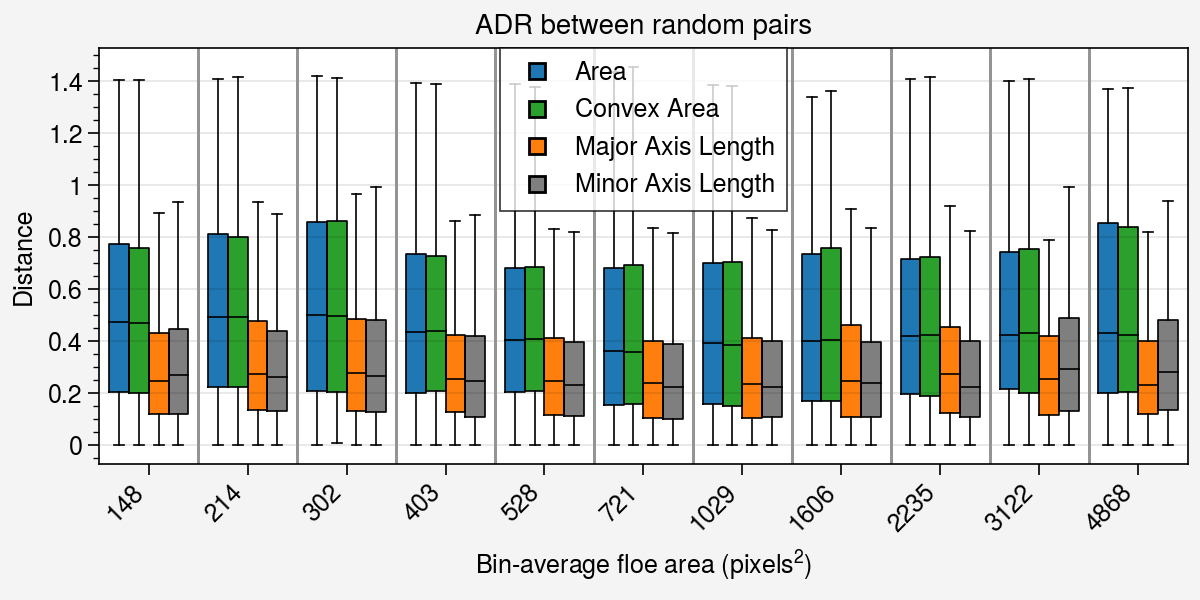

In [44]:
fig, ax = pplt.subplots(width=6, height=3)
h = []
df = df_random.copy()
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(7.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in bin_area_count.area.round().values.squeeze()], xrotation=45,
         title='ADR between random pairs', xlabel='Bin-average floe area (pixels$^2$)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/adr_random_boxplot.png', dpi=300)

Finally, we overlay the matched pair results on the random pair results.

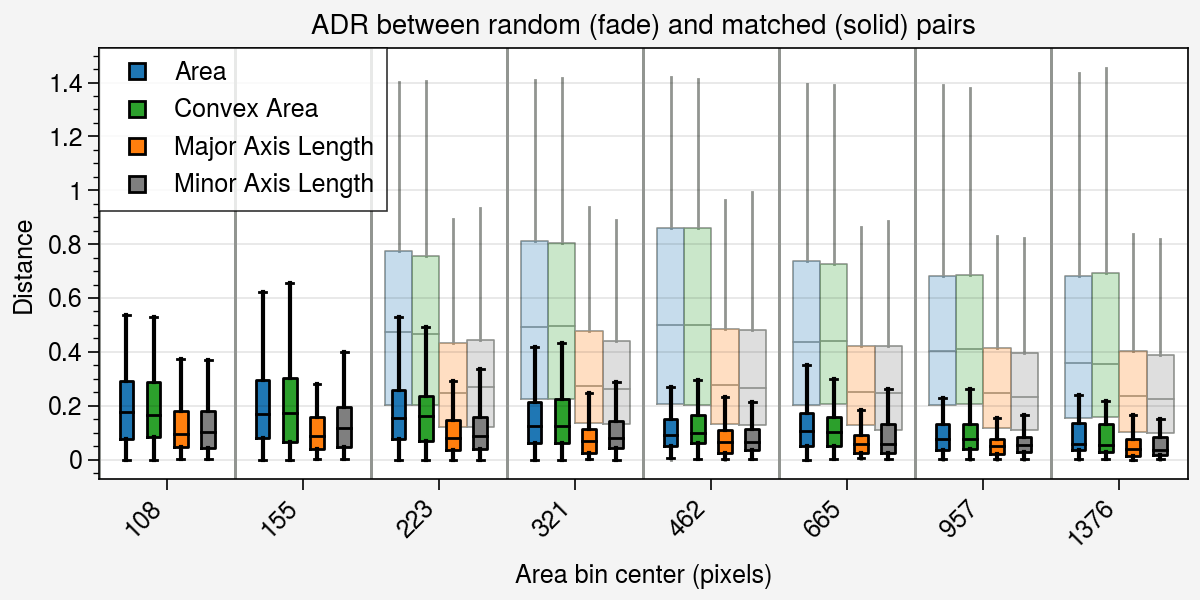

In [45]:
bcenter = 0.5*(bins[1:] + bins[:-1])

fig, ax = pplt.subplots(width=6, height=3)
h = []
df = df_random.copy()
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, whiskerlinewidths=1
           , ec='gray', caplinewidths=0,
           widths=0.2, alpha=0.25, zorder=0)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='light gray')

df = df_merged.copy()
df = df.loc[df.area > 50]
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_area_count['count'] > 20]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.1, zorder=5, lw=1, whiskerlinewidth=1.5)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(5.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in np.round(bcenter[bin_area_count[bin_area_count['count'] > 20].index])], xrotation=45,
         title='ADR between random (fade) and matched (solid) pairs',
          xlabel='Area bin center (pixels)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/adr_merged_random_boxplot.png', dpi=300)

# Summary of tests.
## Rotation errors
The error in ADR measurements due to rotation rate is fairly small, except in the case of convex area. For convex area, median error decreases from 12 to 2.5% as the floe area increases from 50 to over 1200 pixels. Values larger than 15% are possible for floes smaller than 100 pixels. For the other three measurements (area, major axis length, minor axis length), median error decreases from around 8% to less than 1%. 

## Inter-image variation errors
Errors due to differences in best-estimate manual outlines of paired floes give an indication of errors due to the uncertainty in the floe shape. Differences in illumination, cloud cover, and ice compactness affect the accuracy of manual floe identification. The ADR values are much larger for the matched pairs than for the rotated floes, telling us that differences in the appearance of floes from image to image is a larger source of uncertainty than difference in floe orientation. Measures of axis length show smaller ADR values than do the area measures. Both decrease is floe size increases.

## Random errors
Randomly pairing objects within area bins results in nearly constant distributions with area. The matched pair distributions of area, strangely enough, show larger differences than the random pairs. Only with large floes do the differences seem noticebly smaller than the random variations. 

# Finding best-performing thresholds
We can think of this in terms of precision and recall: for each possible threshold, we end up labeling pairings as candidates and non-candidates. A false positive is a candidate that is not a true match, a false negative is rejecting a true match. With 4 metrics, should it be done one at a time? Or with all simultaneously? How sensitive is the final choice?


In [34]:
area_threshold = 0.24
# precision = true positives / (true positives + false positives)
# recall = true positives / (true positives + false negatives)

In [35]:
df_merged['true_match'] = True
df_random['true_match'] = False
df_all = pd.concat([df_random[['area', 'adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length', 'true_match']],
                    df_merged[['area', 'adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length', 'true_match']]])

In [36]:
df_random.columns

Index(['adr_area', 'adr_convex_area', 'adr_major_axis_length',
       'adr_minor_axis_length', 'area_first', 'area_second', 'area',
       'area_bin', 'true_match'],
      dtype='object')

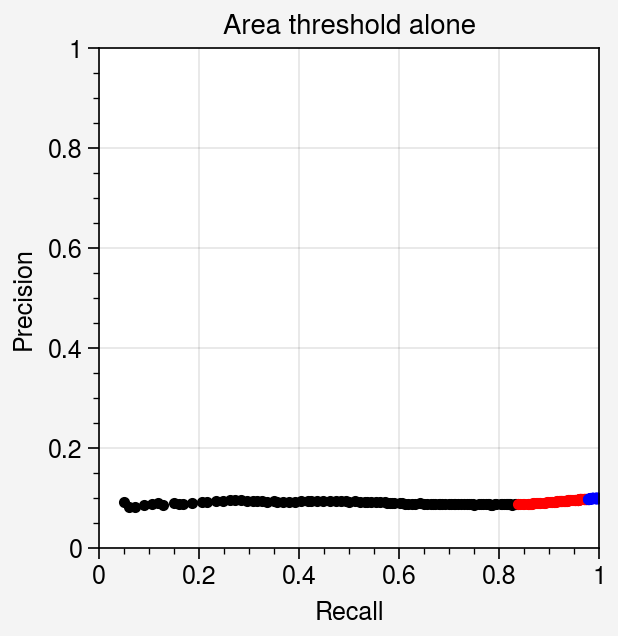

In [37]:
fig, ax = pplt.subplots()
for area_threshold in np.linspace(0.01, 0.3, 100):
    test_result = df_all['adr_area'] < area_threshold
    truth = df_all['true_match']
    precision = np.sum(test_result & truth) / np.sum(test_result)
    recall = np.sum(test_result & truth) / np.sum(truth)
    ax.plot(recall, precision, marker='.', color='k')
for area_threshold in np.linspace(0.3, 0.6, 100):
    test_result = df_all['adr_area'] < area_threshold
    truth = df_all['true_match']
    precision = np.sum(test_result & truth) / np.sum(test_result)
    recall = np.sum(test_result & truth) / np.sum(truth)
    ax.plot(recall, precision, marker='.', color='r')
for area_threshold in np.linspace(0.6, 1, 100):
    test_result = df_all['adr_area'] < area_threshold
    truth = df_all['true_match']
    precision = np.sum(test_result & truth) / np.sum(test_result)
    recall = np.sum(test_result & truth) / np.sum(truth)
    ax.plot(recall, precision, marker='.', color='b')
ax.format(ylim=(0, 1), xlim=(0, 1))
ax.format(ylabel='Precision', xlabel='Recall', title='Area threshold alone')

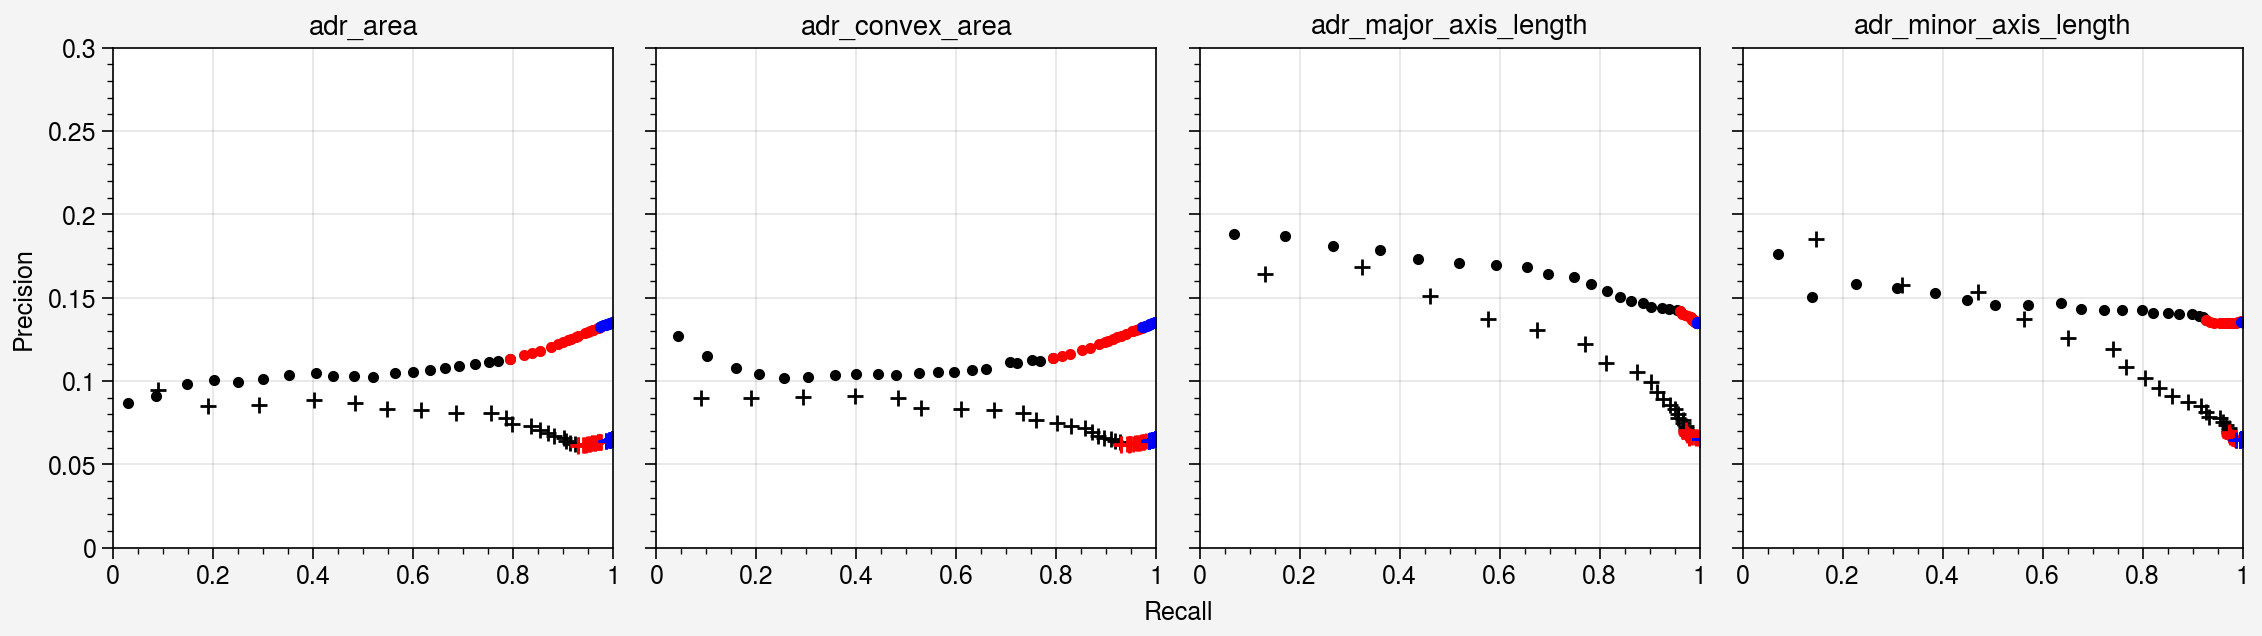

In [38]:
fig, axs = pplt.subplots(ncols=4)
idx = df_all.area < 300
for ax, var in zip(axs, ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']):
    for area_threshold in np.linspace(0.01, 0.3, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='.', color='k')
    for area_threshold in np.linspace(0.3, 0.6, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='.', color='r')
    for area_threshold in np.linspace(0.6, 1, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='.', color='b')
    ax.format(ylim=(0, 1), xlim=(0, 1))
    ax.format(ylabel='Precision', xlabel='Recall', title=var)

idx = df_all.area > 300
for ax, var in zip(axs, ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']):
    for area_threshold in np.linspace(0.01, 0.3, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='+', color='k')
    for area_threshold in np.linspace(0.3, 0.6, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='+', color='r')
    for area_threshold in np.linspace(0.6, 1, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='+', color='b')
    ax.format(ylim=(0, .3), xlim=(0, 1))
    ax.format(ylabel='Precision', xlabel='Recall', title=var)

## Quick notes:
- Circles: small floes. Crosses: large floes
- Black: low thresholds; Red: medium (0.3 to 0.6), Blue: high (0.6 to 1)
- Here, it's all real floe shapes -- the tests may do well at filtering out unrealistic shapes
- Precision is low in all cases. Only minor improvements in precision, while the whole range or recall is possible
- Individual thresholds are not very effective at filtering out bad matches. Possible that a combination of the thresholds is good, though.

In [50]:
import scipy.stats as stats

data = df_all.loc[df_all.true_match, :]
results = []
done = []
for var1 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
    for var2 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
        if var1 != var2:
            pair = [var1, var2]
            pair.sort()
                
            if pair not in done:
                r = stats.pearsonr(data[var1], data[var2])
                c1, c2 = np.round(r.confidence_interval(), 2)
                results.append(['tp', var1, var2, np.round(r.statistic, 2), c1, c2])
                done.append(pair)
data = df_all.loc[~df_all.true_match, :]
done = []
for var1 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
    for var2 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
        if var1 != var2:
            pair = [var1, var2]
            pair.sort()
                
            if pair not in done:
                r = stats.pearsonr(data[var1], data[var2])
                c1, c2 = np.round(r.confidence_interval(), 2)
                results.append(['fp', var1, var2, np.round(r.statistic, 2), c1, c2])
                done.append(pair)
results = pd.DataFrame(results, columns=['match', 'var1', 'var2', 'r', 'cl', 'ch'])

In [51]:
results

,match,var1,var2,r,cl,ch
0,tp,adr_area,adr_convex_area,0.98,0.98,0.99
1,tp,adr_area,adr_major_axis_length,0.69,0.65,0.72
2,tp,adr_area,adr_minor_axis_length,0.75,0.72,0.78
3,tp,adr_convex_area,adr_major_axis_length,0.70,0.67,0.73
4,tp,adr_convex_area,adr_minor_axis_length,0.74,0.71,0.77
5,tp,adr_major_axis_length,adr_minor_axis_length,0.26,0.21,0.32
6,fp,adr_area,adr_convex_area,0.91,0.91,0.92
7,fp,adr_area,adr_major_axis_length,0.10,0.08,0.12
8,fp,adr_area,adr_minor_axis_length,0.15,0.13,0.17
9,fp,adr_convex_area,adr_major_axis_length,0.17,0.15,0.19


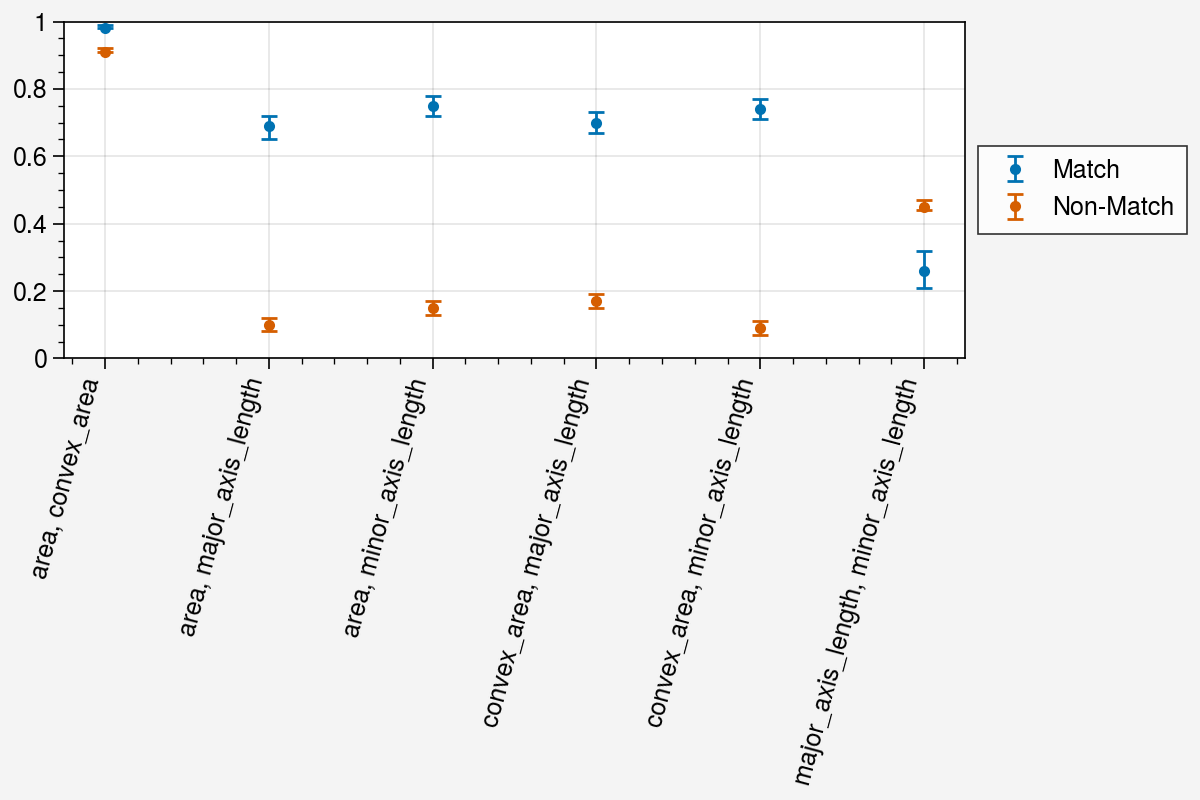

In [52]:
fig, ax = pplt.subplots(width=6, height=4 )
r = results.loc[results.match == 'tp', 'r'].values
cl = results.loc[results.match == 'tp', 'cl'].values
ch = results.loc[results.match == 'tp', 'ch'].values
ax.errorbar(x=np.arange(len(r)),
            y=results.loc[results.match == 'tp', 'r'].values,
            yerr=[r - cl,
                  ch - r], lw=0, elinewidth=1, marker='.',  label='Match')

r = results.loc[results.match == 'fp', 'r'].values
cl = results.loc[results.match == 'fp', 'cl'].values
ch = results.loc[results.match == 'fp', 'ch'].values
ax.errorbar(x=np.arange(len(r)),
            y=results.loc[results.match == 'fp', 'r'].values,
            yerr=[r - cl,
                  ch - r], lw=0, elinewidth=1, marker='.', label='Non-Match')

ax.format(xlocator=np.arange(len(r)), xformatter=[v1.replace('adr_', '') + ', ' + v2.replace('adr_', '') for v1, v2 in zip(
    results.loc[results.match == 'fp', 'var1'],
    results.loc[results.match == 'fp', 'var2'])], xrotation=75, ylim=(0, 1))
ax.legend(ncols=1, loc='r')

In [94]:
import scipy.stats as stats
data = df_all.loc[~df_all.true_match, :]
for var1 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
    for var2 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
        if var1 != var2:
            r = stats.pearsonr(data[var1], data[var2])
            print(np.round(r.statistic, 2), np.round(r.confidence_interval(), 2), var1, var2)

AttributeError: 'DataFrame' object has no attribute 'true_match'

In [54]:
df_all.loc[df_all.true_match, ].corr()

,area,adr_area,adr_convex_area,adr_major_axis_length,adr_minor_axis_length,true_match
area,1.000000,-0.183326,-0.172899,-0.161070,-0.162583,NaN
adr_area,-0.183326,1.000000,0.983296,0.687596,0.749385,NaN
adr_convex_area,-0.172899,0.983296,1.000000,0.699750,0.738298,NaN
adr_major_axis_length,-0.161070,0.687596,0.699750,1.000000,0.264205,NaN
adr_minor_axis_length,-0.162583,0.749385,0.738298,0.264205,1.000000,NaN
true_match,NaN,NaN,NaN,NaN,NaN,NaN


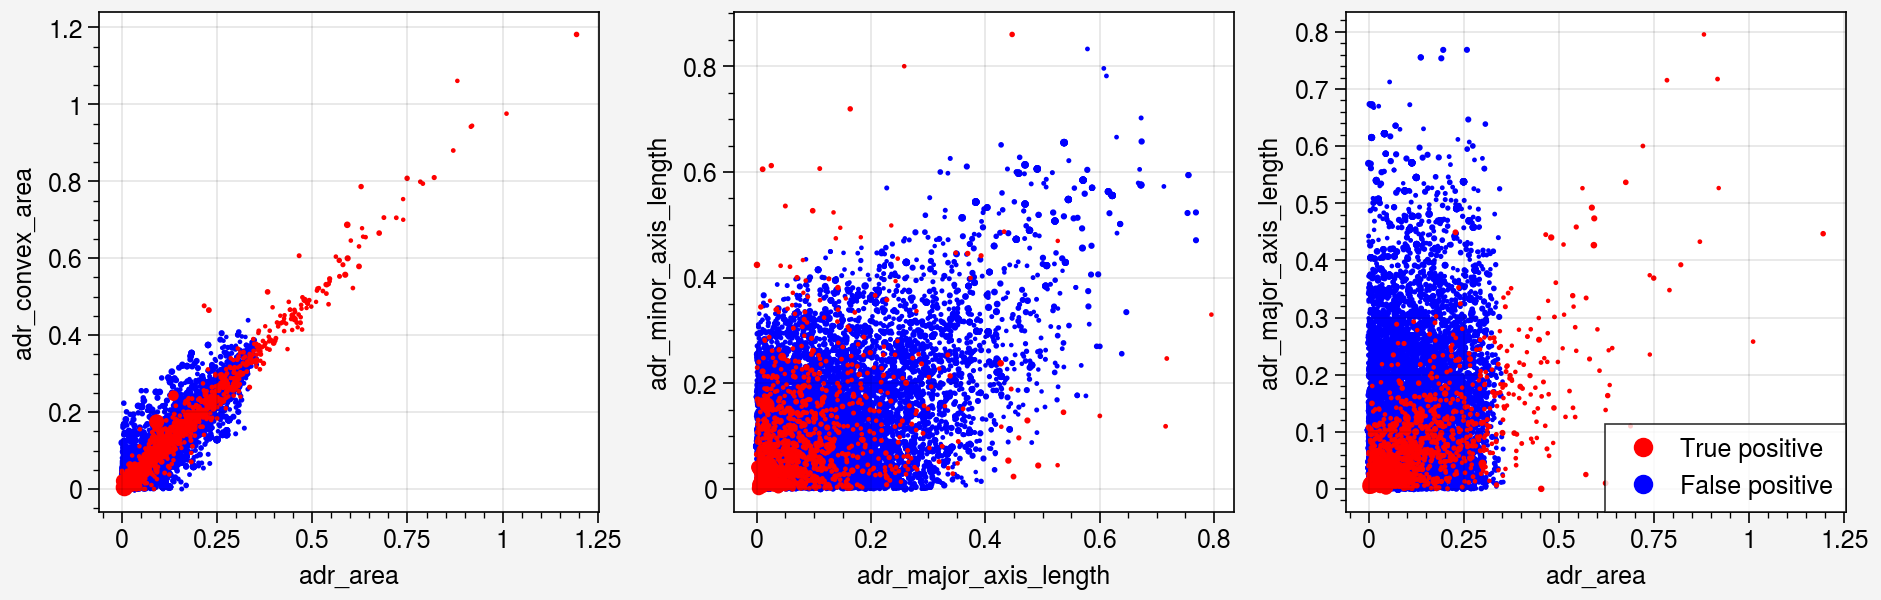

In [55]:
fig, ax = pplt.subplots(ncols=3, share=False)
ax[0].scatter(df_all['adr_area'], df_all['adr_convex_area'], c=df_all['true_match'].astype(int), cmap='bwr', s=df_all['area'])
ax[1].scatter(df_all['adr_major_axis_length'], df_all['adr_minor_axis_length'], c=df_all['true_match'].astype(int), cmap='bwr', s=df_all['area'])
ax[2].scatter(df_all['adr_area'], df_all['adr_major_axis_length'], c=df_all['true_match'].astype(int), cmap='bwr',  s=df_all['area'])
h = [ax[0].plot([],[],m='o', lw=0, color='r'),
      ax[0].plot([],[],m='o', lw=0, color='b')]
ax[2].legend(h, ['True positive', 'False positive'], ncols=1)

# Potential use of joint distribution thresholds
The ADR values for each measure are not independent. The strong mutual correlation (higher than 0.8 across the board in one experiment) tell us that while individual thresholds are not particularly powerful for filtering, combinations of measures may be useful. In the scatterplot above, I've taken the random matches (blue) and the true matches (red) and plotted joint distributions of each. Relative size of the floes is shown by the size of the dots. We can see that the true values tend to be fairly tightly clustered compared to the random values. Thus, we may have better success by looking at either

a. Joint probability distributions in multiple dimensions can be used to assign probabilities
b. Combination measures, such as the ADR of solidity and eccentricity, may have better explanatory power

I also note that the randomization within area bins limits the adr of the area: I should sample a range of sizes instead of within bins.